Tests to implement:

1. KDD/GDD biases
2. LH/SH biases
3. Do these biases scale with ag production
4. Do these biases change over the growing season
5. Do historical cmip6 temperature biases predict future changes

In [183]:
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import cartopy
import cartopy.util
import cartopy.crs as ccrs
import glob
import sys, os
import pickle, gzip
import datetime

In [184]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [185]:
dirCmip6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirERA5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirDeepak = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate/deepak'
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirProj = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'
dirSacks = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'


In [186]:
# files = glob.glob('%s/cmip6_output/*.nc'%dirProj)
# for f in files:
#     os.rename(f,'%s.nc'%f[0:-4]) 

In [187]:
with gzip.open('%s/gdd-kdd-lat-era5.dat'%dirAgData, 'rb') as f:
    era5_lat = pickle.load(f)
with gzip.open('%s/gdd-kdd-lon-era5.dat'%dirAgData, 'rb') as f:
    era5_lon = pickle.load(f)

In [188]:
cmip6_models = ['access-cm2', 'access-esm1-5', 'awi-cm-1-1-mr', 'bcc-csm2-mr', 'bcc-esm1', 'canesm5', 'ec-earth3', \
                'gfdl-cm4', 'gfdl-esm4', 'giss-e2-1-g', 'kace-1-0-g', 'fgoals-g3', 'inm-cm5-0', 'ipsl-cm6a-lr', 'miroc6', \
                'mpi-esm1-2-hr', 'mpi-esm1-2-lr', 'mri-esm2-0', 'noresm2-lm', 'noresm2-mm', 'sam0-unicon']

In [189]:
region = 'global'
crop = 'Maize'
if region == 'global':
    latRange = [-90, 90]
    lonRange = [0, 360]
elif region == 'us':
    latRange = [20, 57]
    lonRange = [220, 300]
elif region == 'china':
    latRange = [25, 45]
    lonRange = [105, 123]
elif region == 'eu':
    latRange = [38, 56]
    lonRange = [-5, 40]

latIndRange_era5 = np.where((era5_lat >= latRange[0]) & (era5_lat <= latRange[1]))[0]
lonIndRange_era5 = np.where((era5_lon >= lonRange[0]) & (era5_lon <= lonRange[1]))[0]

regridMesh_current = xr.Dataset({'lat': (['lat'], np.arange(latRange[0], latRange[1], 1.5)),
                            'lon': (['lon'], np.arange(lonRange[0], lonRange[1], 1.5)),})

regridMesh_global = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 1.5)),
                                'lon': (['lon'], np.arange(0, 360, 1.5)),})


if region == 'global':
    regridMesh = regridMesh_global
else:
    regridMesh = regridMesh_current

In [190]:
sacksMaizeNc = xr.open_dataset('%s/sacks/%s.crop.calendar.fill.nc'%(dirSacks, crop))
sacksStart = sacksMaizeNc['plant'].values
sacksStart = np.roll(sacksStart, -int(sacksStart.shape[1]/2), axis=1)
sacksStart[sacksStart < 0] = np.nan
sacksEnd = sacksMaizeNc['harvest'].values
sacksEnd = np.roll(sacksEnd, -int(sacksEnd.shape[1]/2), axis=1)
sacksEnd[sacksEnd < 0] = np.nan

In [191]:
sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

lat_1 = 70
lat_2 = -60

lat_1_ind = np.where(abs(sacksLat-lat_1) == min(abs(sacksLat-lat_1)))[0]
lat_2_ind = np.where(abs(sacksLat-lat_2) == min(abs(sacksLat-lat_2)))[0]

sacksStart_mon = np.full(sacksStart.shape,np.nan)
sacksEnd_mon = np.full(sacksEnd.shape,np.nan)

# convert sacks day to month
for xlat in range(sacksStart.shape[0]):
    for ylon in range(sacksStart.shape[1]):
        
        if not np.isnan(sacksStart[xlat, ylon]):
            curStart = datetime.datetime.strptime('2020%d'%(round(sacksStart[xlat, ylon])+1), '%Y%j').date().month
            sacksStart_mon[xlat, ylon] = curStart
            
        if not np.isnan(sacksEnd[xlat, ylon]):
            curEnd = datetime.datetime.strptime('2020%d'%(round(sacksEnd[xlat, ylon])+1), '%Y%j').date().month
            sacksEnd_mon[xlat, ylon] = curEnd



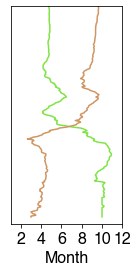

In [192]:
sacksStart_mon_zonal = np.nanmean(sacksStart_mon, axis=1)
sacksEnd_mon_zonal = np.nanmean(sacksEnd_mon, axis=1)

plt.figure(figsize=(2,4))

plt.plot(sacksStart_mon_zonal[lat_1_ind[0]:lat_2_ind[0]], sacksLat[lat_1_ind[0]:lat_2_ind[0]], color='#80e346')
plt.plot(sacksEnd_mon_zonal[lat_1_ind[0]:lat_2_ind[0]], sacksLat[lat_1_ind[0]:lat_2_ind[0]], color='#cf9563')

plt.xlim([1,12])
plt.ylim([-60,70])
plt.xticks(np.arange(2,13,2), fontsize=16);
plt.xlabel('Month', fontsize=16)
plt.gca().yaxis.set_visible(False)

# plt.savefig('growing-season.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [193]:
with open('cropped_area/crop_land_regrid.dat', 'rb') as f:
    crop_all_area_regrid = pickle.load(f)
with open('cropped_area/pasture_land_regrid.dat', 'rb') as f:
    pasture_area_regrid = pickle.load(f)

In [194]:
cmip6_tasmax_grow_max = xr.Dataset()
cmip6_tasmax_grow_mean = xr.Dataset()
cmip6_pr_grow = xr.Dataset()
cmip6_lai_grow = xr.Dataset()
cmip6_tran_grow = xr.Dataset()
cmip6_evspsblveg_grow = xr.Dataset()
cmip6_evspsblsoi_grow = xr.Dataset()
cmip6_cropFrac_grow = xr.Dataset()

pr_m = 0
lai_m = 0
tran_m = 0
evspsblveg_m = 0
evspsblsoi_m = 0
cropFrac_m = 0

for m, model in enumerate(cmip6_models):

    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_tasmax_grow_max_%s_%s_regrid_fixed_sh.nc'%(crop, region, model)):
        print('skipping tasmax max %s'%model)
        
        continue
    
    ds_global_txx = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_max_%s_%s_regrid_fixed_sh.nc'%(crop, region, model))
    ds_global_t50p = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_mean_%s_%s_regrid_fixed_sh.nc'%(crop, region, model))
    
    if m == 0:
        cmip6_tasmax_grow_max = ds_global_txx
        cmip6_tasmax_grow_mean = ds_global_t50p
    else:
        cmip6_tasmax_grow_max = xr.concat([cmip6_tasmax_grow_max, ds_global_txx], dim='model')
        cmip6_tasmax_grow_mean = xr.concat([cmip6_tasmax_grow_mean, ds_global_t50p], dim='model')
    
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_global_%s_regrid_fixed_sh.nc'%(crop, model)):
        ds_global_pr = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_global_%s_regrid_fixed_sh.nc'%(crop, model))
        
        if pr_m == 0:
            cmip6_pr_grow = ds_global_pr
        else:
            cmip6_pr_grow = xr.concat([cmip6_pr_grow, ds_global_pr], dim='model')
        pr_m += 1
#     else:
#         print('skipping pr %s'%model)
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_regrid_fixed_sh.nc'%(crop, model)):
        ds_global_tran = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_regrid_fixed_sh.nc'%(crop, model))
        
        if tran_m == 0:
            cmip6_tran_grow = ds_global_tran
        else:
            cmip6_tran_grow = xr.concat([cmip6_tran_grow, ds_global_tran], dim='model')
        tran_m += 1
#     else:
#         print('skipping tran %s'%model)
        
    
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_evspsblveg_mon_global_%s_regrid_fixed_sh.nc'%(crop, model)):
        ds_global_evspsblveg = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_evspsblveg_mon_global_%s_regrid_fixed_sh.nc'%(crop, model))
        
        if evspsblveg_m == 0:
            cmip6_evspsblveg_grow = ds_global_evspsblveg
        else:
            cmip6_evspsblveg_grow = xr.concat([cmip6_evspsblveg_grow, ds_global_evspsblveg], dim='model')
        evspsblveg_m += 1
#     else:
#         print('skipping evspsblveg %s'%model)
        
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_evspsblsoi_mon_global_%s_regrid_fixed_sh.nc'%(crop, model)):
        ds_global_evspsblsoi = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_evspsblsoi_mon_global_%s_regrid_fixed_sh.nc'%(crop, model))
        
        if evspsblsoi_m == 0:
            cmip6_evspsblsoi_grow = ds_global_evspsblsoi
        else:
            cmip6_evspsblsoi_grow = xr.concat([cmip6_evspsblsoi_grow, ds_global_evspsblsoi], dim='model')
        evspsblsoi_m += 1
#     else:
#         print('skipping evspsblsoi %s'%model)
    
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_cropFrac_mon_global_%s_regrid_fixed_sh.nc'%(crop, model)):
        ds_global_cropFrac = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_cropFrac_mon_global_%s_regrid_fixed_sh.nc'%(crop, model))
        
        if cropFrac_m == 0:
            cmip6_cropFrac_grow = ds_global_cropFrac
        else:
            cmip6_cropFrac_grow = xr.concat([cmip6_cropFrac_grow, ds_global_cropFrac], dim='model')
        cropFrac_m += 1
#     else:
#         print('skipping cropFrac %s'%model)
        
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_lai_mon_global_%s_regrid_fixed_sh.nc'%(crop, model)):
        ds_global_lai = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_lai_mon_global_%s_regrid_fixed_sh.nc'%(crop, model))
        
        if lai_m == 0:
            cmip6_lai_grow = ds_global_lai
        else:
            cmip6_lai_grow = xr.concat([cmip6_lai_grow, ds_global_lai], dim='model')
        lai_m += 1
    else:
        print('skipping lai %s'%model)


skipping lai access-cm2
skipping lai awi-cm-1-1-mr
skipping lai bcc-csm2-mr
skipping lai bcc-esm1
skipping lai ec-earth3
skipping lai kace-1-0-g
skipping lai miroc6
skipping lai mri-esm2-0
skipping lai sam0-unicon


In [254]:
cmip6_lai_grow.model

<xarray.DataArray 'model' (model: 12)>
array(['access-esm1-5', 'canesm5', 'gfdl-cm4', 'gfdl-esm4', 'giss-e2-1-g',
       'fgoals-g3', 'inm-cm5-0', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr',
       'mpi-esm1-2-lr', 'noresm2-lm', 'noresm2-mm'], dtype=object)
Coordinates:
  * model    (model) object 'access-esm1-5' 'canesm5' ... 'noresm2-mm'

In [195]:
# load regridded obs lai climo

lai_obs_regrid = xr.open_dataset('lai_data/lai_%s_grow_mean_regrid_global_fixed_sh.nc'%(crop))

In [196]:
# load era5 growing season temps

era5_tasmax_grow_max_regrid = xr.open_dataset('era5/growing_season/era5_%s_tasmax_grow_max_regrid_%s_fixed_sh.nc'%(crop,region))
era5_tasmax_grow_mean_regrid = xr.open_dataset('era5/growing_season/era5_%s_tasmax_grow_mean_regrid_%s_fixed_sh.nc'%(crop,region))
era5_pr_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_pr_grow_regrid_%s_fixed_sh.nc'%(crop,region))
era5_lai_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_lai_grow_regrid_%s_fixed_sh.nc'%(crop,region))
era5_tran_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_trans_grow_regrid_%s_fixed_sh.nc'%(crop,region))
era5_evap_from_canopy_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_evap_from_canopy_grow_regrid_%s_fixed_sh.nc'%(crop,region))
era5_evap_from_soil_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_evap_from_soil_grow_regrid_%s_fixed_sh.nc'%(crop,region))

era5_pr_grow_regrid_mean = era5_pr_grow_regrid.pr_grow_mean.mean(dim='time').values
era5_tran_grow_regrid_mean = era5_tran_grow_regrid.trans_grow_mean.mean(dim='time').values
era5_evap_from_canopy_grow_regrid_mean = era5_evap_from_canopy_grow_regrid.evap_grow_mean.mean(dim='time').values
era5_evap_from_soil_grow_regrid_mean = era5_evap_from_soil_grow_regrid.evap_grow_mean.mean(dim='time').values


In [197]:
# normalize t by lai

era5_normalized_tran = np.full([era5_lai_grow_regrid.lai_grow_mean.lat.size, era5_lai_grow_regrid.lai_grow_mean.lon.size] , np.nan)

for y in range(era5_lai_grow_regrid.time.size):
    era5_normalized_tran = -np.nanmean(era5_tran_grow_regrid.trans_grow_mean.values, axis=0) / np.nanmean(era5_lai_grow_regrid.lai_grow_mean.values, axis=0)
    
era5_normalized_tran[np.isinf(era5_normalized_tran)] = np.nan

cmip6_normalized_tran = np.full([len(cmip6_models), era5_evap_from_soil_grow_regrid.lat.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lon.values.shape[0]], np.nan)
    

n = 0
for m, model in enumerate(cmip6_models):

    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_lai_mon_global_%s_regrid_fixed_sh.nc'%(crop, model)) \
        or not os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_regrid_fixed_sh.nc'%(crop, model)):
        print('skipping %s'%model)
    else:
        ds_lai = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_lai_mon_global_%s_regrid_fixed_sh.nc'%(crop, model))
        ds_t = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_regrid_fixed_sh.nc'%(crop, model))

        cmip6_normalized_tran[m, :, :] = ds_t.tran_grow_mean.mean(dim='time').values / ds_lai.lai_grow_mean.mean(dim='time').values

cmip6_normalized_tran[np.isinf(cmip6_normalized_tran)] = np.nan
cmip6_normalized_tran[cmip6_normalized_tran>50] = np.nan

skipping access-cm2
skipping access-esm1-5
skipping awi-cm-1-1-mr
skipping bcc-csm2-mr
skipping bcc-esm1
skipping ec-earth3
skipping kace-1-0-g
skipping inm-cm5-0
skipping miroc6
skipping mpi-esm1-2-hr
skipping mpi-esm1-2-lr
skipping mri-esm2-0
skipping sam0-unicon


In [198]:
# load gldas

gldas_noah_tran_grow_mean_regrid = xr.open_dataset('gldas_output/gldas_%s_%s_tran_grow_mean_regrid_%s_fixed_sh.nc'%('NOAH',crop,region))
gldas_noah_soil_evap_grow_mean_regrid = xr.open_dataset('gldas_output/gldas_%s_%s_soil_evap_grow_mean_regrid_%s_fixed_sh.nc'%('NOAH', crop,region))
gldas_noah_canopy_evap_grow_mean_regrid = xr.open_dataset('gldas_output/gldas_%s_%s_canopy_evap_grow_mean_regrid_%s_fixed_sh.nc'%('NOAH',crop,region))
gldas_noah_et_grow_mean_regrid = xr.open_dataset('gldas_output/gldas_%s_%s_et_grow_mean_regrid_%s_fixed_sh.nc'%('NOAH',crop,region))

gldas_vic_tran_grow_mean_regrid = xr.open_dataset('gldas_output/gldas_%s_%s_tran_grow_mean_regrid_%s_fixed_sh.nc'%('VIC',crop,region))
gldas_vic_soil_evap_grow_mean_regrid = xr.open_dataset('gldas_output/gldas_%s_%s_soil_evap_grow_mean_regrid_%s_fixed_sh.nc'%('VIC', crop,region))
gldas_vic_canopy_evap_grow_mean_regrid = xr.open_dataset('gldas_output/gldas_%s_%s_canopy_evap_grow_mean_regrid_%s_fixed_sh.nc'%('VIC',crop,region))
gldas_vic_et_grow_mean_regrid = xr.open_dataset('gldas_output/gldas_%s_%s_et_grow_mean_regrid_%s_fixed_sh.nc'%('VIC',crop,region))

gldas_tran_grow_mean_regrid = (gldas_noah_tran_grow_mean_regrid.evap_grow_mean.values + gldas_vic_tran_grow_mean_regrid.evap_grow_mean.values)/2
gldas_soil_evap_grow_mean_regrid = (gldas_noah_soil_evap_grow_mean_regrid.evap_grow_mean.values + gldas_vic_soil_evap_grow_mean_regrid.evap_grow_mean.values)/2
gldas_canopy_evap_grow_mean_regrid = (gldas_noah_canopy_evap_grow_mean_regrid.evap_grow_mean.values + gldas_vic_canopy_evap_grow_mean_regrid.evap_grow_mean.values)/2
gldas_et_grow_mean_regrid = (gldas_noah_et_grow_mean_regrid.evap_grow_mean.values + gldas_vic_et_grow_mean_regrid.evap_grow_mean.values)/2

In [199]:
# load pre-calculated bias by year

# monthly_groups = cmip6_tasmax_monthly_max.groupby('time.month').groups


yearly_tasmax_grow_max_bias = np.full([len(cmip6_models), era5_tasmax_grow_max_regrid.time.values.shape[0], \
                                  era5_tasmax_grow_max_regrid.lat.values.shape[0], \
                                  era5_tasmax_grow_max_regrid.lon.values.shape[0]], np.nan)
yearly_tasmax_grow_mean_bias = np.full([len(cmip6_models), era5_tasmax_grow_mean_regrid.time.values.shape[0], \
                                  era5_tasmax_grow_mean_regrid.lat.values.shape[0], \
                                  era5_tasmax_grow_mean_regrid.lon.values.shape[0]], np.nan)
yearly_tasmax_grow_max_bias_cpc = np.full([len(cmip6_models), era5_tasmax_grow_max_regrid.time.values.shape[0], \
                                  era5_tasmax_grow_max_regrid.lat.values.shape[0], \
                                  era5_tasmax_grow_max_regrid.lon.values.shape[0]], np.nan)


yearly_pr_grow_bias = np.full([len(cmip6_models), era5_pr_grow_regrid.time.values.shape[0], \
                                   era5_pr_grow_regrid.lat.values.shape[0], \
                                   era5_pr_grow_regrid.lon.values.shape[0]], np.nan)
yearly_pr_grow_bias_rel_gridcell = np.full([len(cmip6_models), era5_pr_grow_regrid.time.values.shape[0], \
                                   era5_pr_grow_regrid.lat.values.shape[0], \
                                   era5_pr_grow_regrid.lon.values.shape[0]], np.nan)
yearly_pr_grow_bias_rel_global_mean = np.full([len(cmip6_models), era5_pr_grow_regrid.time.values.shape[0], \
                                   era5_pr_grow_regrid.lat.values.shape[0], \
                                   era5_pr_grow_regrid.lon.values.shape[0]], np.nan)

yearly_pr_grow_bias_gpcp = np.full([len(cmip6_models), era5_pr_grow_regrid.time.values.shape[0], \
                                   era5_pr_grow_regrid.lat.values.shape[0], \
                                   era5_pr_grow_regrid.lon.values.shape[0]], np.nan)

yearly_tran_grow_bias = np.full([len(cmip6_models), era5_tran_grow_regrid.time.values.shape[0], \
                                   era5_tran_grow_regrid.lat.values.shape[0], \
                                   era5_tran_grow_regrid.lon.values.shape[0]], np.nan)
yearly_tran_grow_bias_rel_gridcell = np.full([len(cmip6_models), era5_tran_grow_regrid.time.values.shape[0], \
                                   era5_tran_grow_regrid.lat.values.shape[0], \
                                   era5_tran_grow_regrid.lon.values.shape[0]], np.nan)
yearly_tran_grow_bias_rel_global_mean = np.full([len(cmip6_models), era5_tran_grow_regrid.time.values.shape[0], \
                                   era5_tran_grow_regrid.lat.values.shape[0], \
                                   era5_tran_grow_regrid.lon.values.shape[0]], np.nan)

yearly_evap_from_canopy_grow_bias = np.full([len(cmip6_models), era5_evap_from_canopy_grow_regrid.time.values.shape[0], \
                                   era5_evap_from_canopy_grow_regrid.lat.values.shape[0], \
                                   era5_evap_from_canopy_grow_regrid.lon.values.shape[0]], np.nan)
yearly_evap_from_canopy_grow_bias_rel_gridcell = np.full([len(cmip6_models), era5_evap_from_canopy_grow_regrid.time.values.shape[0], \
                                   era5_evap_from_canopy_grow_regrid.lat.values.shape[0], \
                                   era5_evap_from_canopy_grow_regrid.lon.values.shape[0]], np.nan)
yearly_evap_from_canopy_grow_bias_rel_global_mean = np.full([len(cmip6_models), era5_evap_from_canopy_grow_regrid.time.values.shape[0], \
                                   era5_evap_from_canopy_grow_regrid.lat.values.shape[0], \
                                   era5_evap_from_canopy_grow_regrid.lon.values.shape[0]], np.nan)

yearly_evap_from_soil_grow_bias = np.full([len(cmip6_models), era5_evap_from_soil_grow_regrid.time.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lat.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lon.values.shape[0]], np.nan)
yearly_evap_from_soil_grow_bias_rel_gridcell = np.full([len(cmip6_models), era5_evap_from_soil_grow_regrid.time.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lat.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lon.values.shape[0]], np.nan)
yearly_evap_from_soil_grow_bias_rel_global_mean = np.full([len(cmip6_models), era5_evap_from_soil_grow_regrid.time.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lat.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lon.values.shape[0]], np.nan)

yearly_tran_grow_bias_gldas = np.full([len(cmip6_models), era5_tasmax_grow_max_regrid.time.values.shape[0], \
                                   era5_tasmax_grow_max_regrid.lat.values.shape[0], \
                                   era5_tasmax_grow_max_regrid.lon.values.shape[0]], np.nan)

yearly_canopy_evap_grow_bias_gldas = np.full([len(cmip6_models), era5_tasmax_grow_max_regrid.time.values.shape[0], \
                                   era5_tasmax_grow_max_regrid.lat.values.shape[0], \
                                   era5_tasmax_grow_max_regrid.lon.values.shape[0]], np.nan)

yearly_soil_evap_grow_bias_gldas = np.full([len(cmip6_models), era5_tasmax_grow_max_regrid.time.values.shape[0], \
                                   era5_tasmax_grow_max_regrid.lat.values.shape[0], \
                                   era5_tasmax_grow_max_regrid.lon.values.shape[0]], np.nan)

yearly_et_grow_bias_gldas = np.full([len(cmip6_models), era5_tasmax_grow_max_regrid.time.values.shape[0], \
                                   era5_tasmax_grow_max_regrid.lat.values.shape[0], \
                                   era5_tasmax_grow_max_regrid.lon.values.shape[0]], np.nan)


yearly_lai_grow_bias = np.full([len(cmip6_models), era5_evap_from_soil_grow_regrid.time.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lat.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lon.values.shape[0]], np.nan)

lai_grow_obs_bias = np.full([len(cmip6_models), \
                                   era5_evap_from_soil_grow_regrid.lat.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lon.values.shape[0]], np.nan)

rel_bias_threshold = 5

for m, model in enumerate(cmip6_models):
    print('loading yearly bias for %s'%model)

    with open('cmip6_output/bias/yearly-cmip6-era5-tasmax-grow-max-bias-%s-%s_fixed_sh.dat'%(region, model), 'rb') as f:
        yearly_tasmax_grow_max_bias[m, :, :, :] = pickle.load(f)
    with open('cmip6_output/bias/yearly-cmip6-era5-tasmax-grow-mean-bias-%s-%s_fixed_sh.dat'%(region, model), 'rb') as f:
        yearly_tasmax_grow_mean_bias[m, :, :, :] = pickle.load(f)
    with open('cmip6_output/bias/yearly-cmip6-cpc-tasmax-grow-max-bias-%s-%s-fixed-sh.dat'%(region, model), 'rb') as f:
        yearly_tasmax_grow_max_bias_cpc[m, :, :, :] = pickle.load(f)
        
        
    
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-pr-grow-bias-%s-%s-fixed-sh.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-pr-grow-bias-%s-%s-fixed-sh.dat'%(region, model), 'rb') as f:
            yearly_pr_grow_bias[m, :, :, :] = pickle.load(f)
            
            yearly_pr_grow_bias_global_mean_rel = np.nanmean(np.nanmean(np.nanmean(yearly_pr_grow_bias[m,:,:,:])))/np.nanmean(np.nanmean(era5_pr_grow_regrid_mean))*100
            
            for y in range(yearly_pr_grow_bias.shape[1]):
                tmp = yearly_pr_grow_bias[m, y, :, :]/era5_pr_grow_regrid_mean*100
                tmp[abs(tmp)>rel_bias_threshold*100] = np.nan
                yearly_pr_grow_bias_rel_gridcell[m, y, :, :] = tmp
                
                yearly_pr_grow_bias_rel_global_mean[m, y, :, :] = yearly_pr_grow_bias_rel_gridcell[m, y, :, :] - yearly_pr_grow_bias_global_mean_rel
                
                
                
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-gpcp-pr-grow-bias-%s-%s-fixed-sh.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-gpcp-pr-grow-bias-%s-%s-fixed-sh.dat'%(region, model), 'rb') as f:
            yearly_pr_grow_bias_gpcp[m, :, :, :] = pickle.load(f)
                
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-tran-grow-bias-%s-%s-fixed-sh.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-tran-grow-bias-%s-%s-fixed-sh.dat'%(region, model), 'rb') as f:
            yearly_tran_grow_bias[m, :, :, :] = pickle.load(f)
            
            yearly_tran_grow_bias_global_mean_rel = np.nanmean(np.nanmean(np.nanmean(yearly_tran_grow_bias[m,:,:,:])))/np.nanmean(np.nanmean(era5_tran_grow_regrid_mean))*100
            
            for y in range(yearly_tran_grow_bias.shape[1]):
                tmp = yearly_tran_grow_bias[m, y, :, :]/-era5_tran_grow_regrid_mean*100
                tmp[abs(tmp)>rel_bias_threshold*100] = np.nan
                yearly_tran_grow_bias_rel_gridcell[m, y, :, :] = tmp
                
                yearly_tran_grow_bias_rel_global_mean[m, y, :, :] = yearly_tran_grow_bias_rel_gridcell[m, y, :, :] - yearly_tran_grow_bias_global_mean_rel
            
                
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-evap_from_canopy-grow-bias-%s-%s-fixed-sh.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-evap_from_canopy-grow-bias-%s-%s-fixed-sh.dat'%(region, model), 'rb') as f:
            yearly_evap_from_canopy_grow_bias[m, :, :, :] = pickle.load(f)
            
            yearly_evap_from_canopy_grow_bias_global_mean_rel = np.nanmean(np.nanmean(np.nanmean(yearly_evap_from_canopy_grow_bias[m,:,:,:])))/np.nanmean(np.nanmean(era5_evap_from_canopy_grow_regrid_mean))*100
            
            for y in range(yearly_evap_from_canopy_grow_bias.shape[1]):
                tmp = yearly_evap_from_canopy_grow_bias[m, y, :, :]/-era5_evap_from_canopy_grow_regrid_mean*100
                tmp[abs(tmp)>rel_bias_threshold*100] = np.nan
                yearly_evap_from_canopy_grow_bias_rel_gridcell[m, y, :, :] = tmp
                
                yearly_evap_from_canopy_grow_bias_rel_global_mean[m, y, :, :] = yearly_evap_from_canopy_grow_bias_rel_gridcell[m, y, :, :] - yearly_evap_from_canopy_grow_bias_global_mean_rel
                
            
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-evap_from_soil-grow-bias-%s-%s-fixed-sh.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-evap_from_soil-grow-bias-%s-%s-fixed-sh.dat'%(region, model), 'rb') as f:
            yearly_evap_from_soil_grow_bias[m, :, :, :] = pickle.load(f)
            
            yearly_evap_from_soil_grow_bias_global_mean_rel = np.nanmean(np.nanmean(np.nanmean(yearly_evap_from_soil_grow_bias[m,:,:,:])))/np.nanmean(np.nanmean(era5_evap_from_soil_grow_regrid_mean))*100
            
            for y in range(yearly_evap_from_soil_grow_bias.shape[1]):
                tmp = yearly_evap_from_soil_grow_bias[m, y, :, :]/-era5_evap_from_soil_grow_regrid_mean*100
                tmp[abs(tmp)>rel_bias_threshold*100] = np.nan
                yearly_evap_from_soil_grow_bias_rel_gridcell[m, y, :, :] = tmp 
                
                yearly_evap_from_soil_grow_bias_rel_global_mean[m, y, :, :] = yearly_evap_from_soil_grow_bias_rel_gridcell[m, y, :, :] - yearly_evap_from_soil_grow_bias_global_mean_rel
                
    
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-gldas-tran-grow-bias-%s-%s-fixed-sh.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-gldas-tran-grow-bias-%s-%s-fixed-sh.dat'%(region, model), 'rb') as f:
            yearly_tran_grow_bias_gldas[m, :, :, :] = pickle.load(f)
    
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-gldas-canopy-evap-grow-bias-%s-%s-fixed-sh.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-gldas-canopy-evap-grow-bias-%s-%s-fixed-sh.dat'%(region, model), 'rb') as f:
            yearly_canopy_evap_grow_bias_gldas[m, :, :, :] = pickle.load(f)
    
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-gldas-soil-evap-grow-bias-%s-%s-fixed-sh.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-gldas-soil-evap-grow-bias-%s-%s-fixed-sh.dat'%(region, model), 'rb') as f:
            yearly_soil_evap_grow_bias_gldas[m, :, :, :] = pickle.load(f)
    
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-gldas-et-grow-bias-%s-%s-fixed-sh.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-gldas-et-grow-bias-%s-%s-fixed-sh.dat'%(region, model), 'rb') as f:
            yearly_et_grow_bias_gldas[m, :, :, :] = pickle.load(f)
    
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-lai-grow-bias-%s-%s-fixed-sh.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-lai-grow-bias-%s-%s-fixed-sh.dat'%(region, model), 'rb') as f:
            yearly_lai_grow_bias[m, :, :, :] = pickle.load(f)
            
            
    if os.path.isfile('cmip6_output/bias/climo-cmip6-obs-lai-grow-bias-%s-%s-fixed-sh.dat'%(region, model)):
        with open('cmip6_output/bias/climo-cmip6-obs-lai-grow-bias-%s-%s-fixed-sh.dat'%(region, model), 'rb') as f:
            lai_grow_obs_bias[m, :, :] = pickle.load(f)
            


loading yearly bias for access-cm2
loading yearly bias for access-esm1-5
loading yearly bias for awi-cm-1-1-mr
loading yearly bias for bcc-csm2-mr
loading yearly bias for bcc-esm1
loading yearly bias for canesm5
loading yearly bias for ec-earth3
loading yearly bias for gfdl-cm4
loading yearly bias for gfdl-esm4
loading yearly bias for giss-e2-1-g
loading yearly bias for kace-1-0-g
loading yearly bias for fgoals-g3
loading yearly bias for inm-cm5-0
loading yearly bias for ipsl-cm6a-lr
loading yearly bias for miroc6
loading yearly bias for mpi-esm1-2-hr
loading yearly bias for mpi-esm1-2-lr
loading yearly bias for mri-esm2-0
loading yearly bias for noresm2-lm
loading yearly bias for noresm2-mm
loading yearly bias for sam0-unicon


In [200]:
et_bias_gldas = yearly_tran_grow_bias_gldas + yearly_canopy_evap_grow_bias_gldas + yearly_soil_evap_grow_bias_gldas
et_bias_era5 = yearly_tran_grow_bias + yearly_evap_from_canopy_grow_bias + yearly_evap_from_soil_grow_bias

In [201]:
import numpy.ma as ma

crop_area_mask = crop_all_area_regrid.copy()
crop_area_mask[crop_area_mask == 0] = False
crop_area_mask[np.isnan(crop_area_mask)] = False
crop_area_mask[crop_area_mask > 0] = True
crop_area_mask = ma.make_mask(crop_area_mask)

In [202]:

era5_t_et = xr.open_dataset('era5/growing_season/era5_t_et_grow_%s_fixed_sh.nc'%region)
gldas_t_et = xr.open_dataset('gldas_output/gldas_t_et_grow_%s_fixed_sh.nc'%region)
    
era5_t_pr = xr.open_dataset('era5/growing_season/era5_t_pr_grow_%s_fixed_sh.nc'%region)
    
cmip6_t_et_grow = xr.Dataset()
cmip6_t_et_grow_bias = np.full([len(cmip6_models), era5_evap_from_soil_grow_regrid.lat.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lon.values.shape[0]], np.nan)
cmip6_t_et_grow_bias_gldas = np.full([len(cmip6_models), era5_evap_from_soil_grow_regrid.lat.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lon.values.shape[0]], np.nan)

cmip6_t_pr_grow = np.full([len(cmip6_models), era5_tran_grow_regrid.lat.values.shape[0], \
                                   era5_tran_grow_regrid.lon.values.shape[0]], np.nan)
cmip6_t_pr_grow_bias = np.full([len(cmip6_models), era5_tran_grow_regrid.lat.values.shape[0], \
                                   era5_tran_grow_regrid.lon.values.shape[0]], np.nan)

n = 0
n2 = 0
for m, model in enumerate(cmip6_models):

    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_t_et_mon_global_%s_regrid_fixed_sh.nc'%(crop, model)):
            
        print('t_et %s'%model)
        ds_t_et = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_t_et_mon_global_%s_regrid_fixed_sh.nc'%(crop, model))

        if n == 0:
            cmip6_t_et_grow = ds_t_et
            cmip6_t_et_grow_bias[m, :, :] = ds_t_et.t_et_grow_mean.mean(dim='time') - era5_t_et.t_et_grow_mean.mean(dim='time')
            cmip6_t_et_grow_bias_gldas[m, :, :] = ds_t_et.t_et_grow_mean.mean(dim='time') - gldas_t_et.t_et_grow_mean.mean(dim='time')
            n += 1
        else:
            cmip6_t_et_grow = xr.concat([cmip6_t_et_grow, ds_t_et], dim='model')
            cmip6_t_et_grow_bias[m, :, :] = ds_t_et.t_et_grow_mean.mean(dim='time') - era5_t_et.t_et_grow_mean.mean(dim='time')
            cmip6_t_et_grow_bias_gldas[m, :, :] = ds_t_et.t_et_grow_mean.mean(dim='time') - gldas_t_et.t_et_grow_mean.mean(dim='time')
            n += 1
            
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_t_pr_mon_global_%s_regrid_fixed_sh.nc'%(crop, model)):
        
        print('t_pr %s'%model)
        ds_t_pr = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_t_pr_mon_global_%s_regrid_fixed_sh.nc'%(crop, model))

        if n2 == 0:
            cmip6_t_pr_grow = ds_t_pr
            cmip6_t_pr_grow_bias[m, :, :] = ds_t_pr.t_pr_grow_mean.mean(dim='time') - era5_t_pr.t_pr_grow_mean.mean(dim='time')
            n2 += 1
        else:
            cmip6_t_pr_grow = xr.concat([cmip6_t_pr_grow, ds_t_pr], dim='model')
            cmip6_t_pr_grow_bias[m, :, :] = ds_t_pr.t_pr_grow_mean.mean(dim='time') - era5_t_pr.t_pr_grow_mean.mean(dim='time')
            n2 += 1
        
            
    
    


t_et bcc-csm2-mr
t_et bcc-esm1
t_pr bcc-esm1
t_et canesm5
t_pr canesm5
t_pr gfdl-esm4
t_et kace-1-0-g
t_pr kace-1-0-g
t_pr fgoals-g3
t_et ipsl-cm6a-lr
t_pr ipsl-cm6a-lr
t_et miroc6
t_pr miroc6
t_et mri-esm2-0
t_pr mri-esm2-0
t_pr noresm2-lm


In [203]:
# crop4_area_regrid_1d = np.reshape(crop4_area_regrid_15, [crop4_area_regrid_15.size,1])
crop_all_area_regrid_1d = np.reshape(crop_all_area_regrid, [crop_all_area_regrid.size,1])

In [204]:
%%time
if not os.path.isfile('irrigation_data_regrid_120_240.dat'):
    faoIrrigationFile = '%s/fao-irrigation/gmia_v5_aei_pct.asc'%dirAgData
    irrigationData = np.genfromtxt(faoIrrigationFile, skip_header=6)
    irrigationLat = np.linspace(90,-90,irrigationData.shape[0])
    irrigationLon = np.linspace(-180,180,irrigationData.shape[1])
    irrigationLon[irrigationLon<0] += 360

    regridder = xe.Regridder(xr.DataArray(data=irrigationData, dims=['lat', 'lon'], coords={'lat':irrigationLat, 'lon':irrigationLon}), regridMesh, 'bilinear')
    irrigation_data_regrid = regridder(irrigationData)

    with open('irrigation_data_regrid_120_240.dat', 'wb') as f:
        pickle.dump(irrigation_data_regrid, f)
else:
    with open('irrigation_data_regrid_120_240.dat', 'rb') as f:
        irrigation_data_regrid = pickle.load(f)
    irrigation_data_regrid[irrigation_data_regrid == 0] = np.nan
    irrigation_data_regrid /= 100
    irrigation_data_regrid_1d = irrigation_data_regrid.reshape([irrigation_data_regrid.shape[0]*irrigation_data_regrid.shape[1],1])

CPU times: user 0 ns, sys: 2.13 ms, total: 2.13 ms
Wall time: 41.7 ms


In [205]:
cmip6_ha_bias = np.full([len(cmip6_models), cmip6_cropFrac_grow.lat.size, cmip6_cropFrac_grow.lon.size], np.nan)

cmip6_cropFrac_grow_mean = cmip6_cropFrac_grow.grow_cropFrac.mean(dim='time').values

m_rel = 0
for m in range(len(cmip6_models)):
    if cmip6_models[m] in cmip6_cropFrac_grow.model.values:
        print('processing model %s'%cmip6_cropFrac_grow.model[m_rel])
        for xlat in range(cmip6_ha_bias.shape[1]):
            for ylon in range(cmip6_ha_bias.shape[2]):
                cmip6_ha_bias[m_rel, xlat, ylon] = cmip6_cropFrac_grow_mean[m_rel, xlat, ylon]-crop_all_area_regrid[xlat, ylon]*100
        m_rel += 1

processing model <xarray.DataArray 'model' ()>
array('access-cm2', dtype='<U10')
Coordinates:
    model    <U10 'access-cm2'
processing model <xarray.DataArray 'model' ()>
array('access-esm1-5', dtype='<U13')
Coordinates:
    model    <U13 'access-esm1-5'
processing model <xarray.DataArray 'model' ()>
array('canesm5', dtype='<U7')
Coordinates:
    model    <U7 'canesm5'
processing model <xarray.DataArray 'model' ()>
array('gfdl-cm4', dtype='<U8')
Coordinates:
    model    <U8 'gfdl-cm4'
processing model <xarray.DataArray 'model' ()>
array('gfdl-esm4', dtype='<U9')
Coordinates:
    model    <U9 'gfdl-esm4'
processing model <xarray.DataArray 'model' ()>
array('inm-cm5-0', dtype='<U9')
Coordinates:
    model    <U9 'inm-cm5-0'
processing model <xarray.DataArray 'model' ()>
array('ipsl-cm6a-lr', dtype='<U12')
Coordinates:
    model    <U12 'ipsl-cm6a-lr'
processing model <xarray.DataArray 'model' ()>
array('mpi-esm1-2-hr', dtype='<U13')
Coordinates:
    model    <U13 'mpi-esm1-2-hr'
proces

In [206]:
yearly_tasmax_grow_max_bias_mean = np.nanmean(np.nanmean(yearly_tasmax_grow_max_bias, axis=0), axis=0)
yearly_tasmax_grow_mean_bias_mean = np.nanmean(np.nanmean(yearly_tasmax_grow_mean_bias, axis=0), axis=0)
yearly_tasmax_grow_max_bias_cpc_mean = np.nanmean(np.nanmean(yearly_tasmax_grow_max_bias_cpc, axis=0), axis=0)

yearly_pr_grow_bias_mean = np.nanmean(np.nanmean(yearly_pr_grow_bias, axis=0), axis=0)
yearly_pr_grow_bias_gpcp_mean = np.nanmean(np.nanmean(yearly_pr_grow_bias_gpcp, axis=0), axis=0)

yearly_tran_grow_bias_mean = np.nanmean(np.nanmean(yearly_tran_grow_bias, axis=1), axis=0)
yearly_et_grow_bias_mean = np.nanmean(np.nanmean(et_bias_era5, axis=1), axis=0)
yearly_evap_from_canopy_grow_bias_mean = np.nanmean(np.nanmean(yearly_evap_from_canopy_grow_bias, axis=1), axis=0)
yearly_evap_from_soil_grow_bias_mean = np.nanmean(np.nanmean(yearly_evap_from_soil_grow_bias, axis=1), axis=0)
yearly_lai_grow_bias_mean = np.nanmean(np.nanmean(yearly_lai_grow_bias, axis=1), axis=0)
lai_grow_obs_bias_mean = np.nanmean(lai_grow_obs_bias, axis=0)

yearly_pr_grow_bias_mean_rel_gridcell = np.nanmean(np.nanmean(yearly_pr_grow_bias_rel_gridcell, axis=0), axis=0)
yearly_tran_grow_bias_mean_rel_gridcell = np.nanmean(np.nanmean(yearly_tran_grow_bias_rel_gridcell, axis=0), axis=0)
yearly_evap_from_canopy_grow_bias_mean_rel_gridcell = np.nanmean(np.nanmean(yearly_evap_from_canopy_grow_bias_rel_gridcell, axis=0), axis=0)
yearly_evap_from_soil_grow_bias_mean_rel_gridcell = np.nanmean(np.nanmean(yearly_evap_from_soil_grow_bias_rel_gridcell, axis=0), axis=0)

yearly_pr_grow_bias_mean_rel_global_mean = np.nanmean(np.nanmean(yearly_pr_grow_bias_rel_global_mean, axis=0), axis=0)
yearly_tran_grow_bias_mean_rel_global_mean = np.nanmean(np.nanmean(yearly_tran_grow_bias_rel_global_mean, axis=0), axis=0)
yearly_evap_from_canopy_grow_bias_mean_rel_global_mean = np.nanmean(np.nanmean(yearly_evap_from_canopy_grow_bias_rel_global_mean, axis=0), axis=0)
yearly_evap_from_soil_grow_bias_mean_rel_global_mean = np.nanmean(np.nanmean(yearly_evap_from_soil_grow_bias_rel_global_mean, axis=0), axis=0)

yearly_tran_grow_bias_gldas_mean = np.nanmean(np.nanmean(yearly_tran_grow_bias_gldas, axis=1), axis=0)
yearly_canopy_evap_grow_bias_gldas_mean = np.nanmean(np.nanmean(yearly_canopy_evap_grow_bias_gldas, axis=1), axis=0)
yearly_soil_evap_grow_bias_gldas_mean = np.nanmean(np.nanmean(yearly_soil_evap_grow_bias_gldas, axis=1), axis=0)
yearly_et_grow_bias_gldas_mean = np.nanmean(np.nanmean(et_bias_gldas, axis=1), axis=0)

yearly_tasmax_grow_max_bias_mean_1d = yearly_tasmax_grow_max_bias_mean.reshape([yearly_tasmax_grow_max_bias_mean.size, 1])
yearly_tasmax_grow_mean_bias_mean_1d = yearly_tasmax_grow_mean_bias_mean.reshape([yearly_tasmax_grow_mean_bias_mean.size, 1])
yearly_tasmax_grow_max_bias_cpc_mean_1d = yearly_tasmax_grow_max_bias_cpc_mean.reshape([yearly_tasmax_grow_max_bias_cpc_mean.size, 1])

yearly_pr_grow_bias_mean_1d = yearly_pr_grow_bias_mean.reshape([yearly_pr_grow_bias_mean.size, 1])
yearly_pr_grow_bias_gpcp_mean_1d = yearly_pr_grow_bias_gpcp_mean.reshape([yearly_pr_grow_bias_gpcp_mean.size, 1])
yearly_tran_grow_bias_mean_1d = yearly_tran_grow_bias_mean.reshape([yearly_tran_grow_bias_mean.size, 1])
yearly_et_grow_bias_mean_1d = yearly_et_grow_bias_mean.reshape([yearly_et_grow_bias_mean.size, 1])
yearly_evap_from_canopy_grow_bias_mean_1d = yearly_evap_from_canopy_grow_bias_mean.reshape([yearly_evap_from_canopy_grow_bias_mean.size, 1])
yearly_evap_from_soil_grow_bias_mean_1d = yearly_evap_from_soil_grow_bias_mean.reshape([yearly_evap_from_soil_grow_bias_mean.size, 1])
yearly_lai_grow_bias_mean_1d = yearly_lai_grow_bias_mean.reshape([yearly_lai_grow_bias_mean.size, 1])
lai_grow_obs_bias_mean_1d = lai_grow_obs_bias_mean.reshape([lai_grow_obs_bias_mean.size, 1])

yearly_pr_grow_bias_mean_rel_gridcell_1d = yearly_pr_grow_bias_mean_rel_gridcell.reshape([yearly_pr_grow_bias_mean_rel_gridcell.size, 1])
yearly_tran_grow_bias_mean_rel_gridcell_1d = yearly_tran_grow_bias_mean_rel_gridcell.reshape([yearly_tran_grow_bias_mean_rel_gridcell.size, 1])
yearly_evap_from_canopy_grow_bias_mean_rel_gridcell_1d = yearly_evap_from_canopy_grow_bias_mean_rel_gridcell.reshape([yearly_evap_from_canopy_grow_bias_mean_rel_gridcell.size, 1])
yearly_evap_from_soil_grow_bias_mean_rel_gridcell_1d = yearly_evap_from_soil_grow_bias_mean_rel_gridcell.reshape([yearly_evap_from_soil_grow_bias_mean_rel_gridcell.size, 1])

yearly_pr_grow_bias_mean_rel_global_mean_1d = yearly_pr_grow_bias_mean_rel_global_mean.reshape([yearly_pr_grow_bias_mean_rel_global_mean.size, 1])
yearly_tran_grow_bias_mean_rel_global_mean_1d = yearly_tran_grow_bias_mean_rel_global_mean.reshape([yearly_tran_grow_bias_mean_rel_global_mean.size, 1])
yearly_evap_from_canopy_grow_bias_mean_rel_global_mean_1d = yearly_evap_from_canopy_grow_bias_mean_rel_global_mean.reshape([yearly_evap_from_canopy_grow_bias_mean_rel_global_mean.size, 1])
yearly_evap_from_soil_grow_bias_mean_rel_global_mean_1d = yearly_evap_from_soil_grow_bias_mean_rel_global_mean.reshape([yearly_evap_from_soil_grow_bias_mean_rel_global_mean.size, 1])

yearly_tran_grow_bias_gldas_mean_1d = yearly_tran_grow_bias_gldas_mean.reshape([yearly_tran_grow_bias_gldas_mean.size, 1])
yearly_canopy_evap_grow_bias_gldas_mean_1d = yearly_canopy_evap_grow_bias_gldas_mean.reshape([yearly_canopy_evap_grow_bias_gldas_mean.size, 1])
yearly_soil_evap_grow_bias_gldas_mean_1d = yearly_soil_evap_grow_bias_gldas_mean.reshape([yearly_soil_evap_grow_bias_gldas_mean.size, 1])
yearly_et_grow_bias_gldas_mean_1d = yearly_et_grow_bias_gldas_mean.reshape([yearly_et_grow_bias_gldas_mean.size, 1])

lai_obs_regrid_1d = lai_obs_regrid.lai_grow_mean.values.reshape([lai_obs_regrid.lai_grow_mean.values.size, 1])

tran_bias_time_mean = np.nanmean(yearly_tran_grow_bias, axis=1)
tran_bias_time_mean_2d = tran_bias_time_mean.reshape([tran_bias_time_mean.shape[0], tran_bias_time_mean.shape[1]*tran_bias_time_mean.shape[2]])

evap_canopy_bias_time_mean = np.nanmean(yearly_evap_from_canopy_grow_bias, axis=1)
evap_canopy_bias_time_mean_2d = evap_canopy_bias_time_mean.reshape([evap_canopy_bias_time_mean.shape[0], evap_canopy_bias_time_mean.shape[1]*evap_canopy_bias_time_mean.shape[2]])

evap_soil_bias_time_mean = np.nanmean(yearly_evap_from_soil_grow_bias, axis=1)
evap_soil_bias_time_mean_2d = evap_soil_bias_time_mean.reshape([evap_soil_bias_time_mean.shape[0], evap_soil_bias_time_mean.shape[1]*evap_soil_bias_time_mean.shape[2]])

tran_bias_time_mean_gldas = np.nanmean(yearly_tran_grow_bias_gldas, axis=1)
tran_bias_time_mean_gldas_2d = tran_bias_time_mean_gldas.reshape([tran_bias_time_mean_gldas.shape[0], tran_bias_time_mean_gldas.shape[1]*tran_bias_time_mean_gldas.shape[2]])

evap_canopy_bias_time_mean_gldas = np.nanmean(yearly_canopy_evap_grow_bias_gldas, axis=1)
evap_canopy_bias_time_mean_gldas_2d = evap_canopy_bias_time_mean_gldas.reshape([evap_canopy_bias_time_mean_gldas.shape[0], evap_canopy_bias_time_mean_gldas.shape[1]*evap_canopy_bias_time_mean_gldas.shape[2]])

evap_soil_bias_time_mean_gldas = np.nanmean(yearly_soil_evap_grow_bias_gldas, axis=1)
evap_soil_bias_time_mean_gldas_2d = evap_soil_bias_time_mean_gldas.reshape([evap_soil_bias_time_mean_gldas.shape[0], evap_soil_bias_time_mean_gldas.shape[1]*evap_soil_bias_time_mean_gldas.shape[2]])


pr_bias_time_mean = np.nanmean(yearly_pr_grow_bias, axis=1)
pr_bias_time_mean_2d = pr_bias_time_mean.reshape([pr_bias_time_mean.shape[0], pr_bias_time_mean.shape[1]*pr_bias_time_mean.shape[2]])

pr_bias_gpcp_time_mean = np.nanmean(yearly_pr_grow_bias_gpcp, axis=1)
pr_bias_gpcp_time_mean_2d = pr_bias_gpcp_time_mean.reshape([pr_bias_gpcp_time_mean.shape[0], pr_bias_gpcp_time_mean.shape[1]*pr_bias_gpcp_time_mean.shape[2]])

tasmax_grow_max_bias_time_mean_2d = np.nanmean(yearly_tasmax_grow_max_bias, axis=1)
tasmax_grow_max_bias_time_mean_2d = tasmax_grow_max_bias_time_mean_2d.reshape([tasmax_grow_max_bias_time_mean_2d.shape[0], tasmax_grow_max_bias_time_mean_2d.shape[1]*tasmax_grow_max_bias_time_mean_2d.shape[2]])

tasmax_grow_mean_bias_time_mean_2d = np.nanmean(yearly_tasmax_grow_mean_bias, axis=1)
tasmax_grow_mean_bias_time_mean_2d = tasmax_grow_mean_bias_time_mean_2d.reshape([tasmax_grow_mean_bias_time_mean_2d.shape[0], tasmax_grow_mean_bias_time_mean_2d.shape[1]*tasmax_grow_mean_bias_time_mean_2d.shape[2]])

tasmax_grow_max_bias_cpc_time_mean_2d = np.nanmean(yearly_tasmax_grow_max_bias_cpc, axis=1)
tasmax_grow_max_bias_cpc_time_mean_2d = tasmax_grow_max_bias_cpc_time_mean_2d.reshape([tasmax_grow_max_bias_cpc_time_mean_2d.shape[0], tasmax_grow_max_bias_cpc_time_mean_2d.shape[1]*tasmax_grow_max_bias_cpc_time_mean_2d.shape[2]])

lai_grow_bias_time_mean_2d = np.nanmean(yearly_lai_grow_bias, axis=1)
lai_grow_bias_time_mean_2d = lai_grow_bias_time_mean_2d.reshape([lai_grow_bias_time_mean_2d.shape[0], lai_grow_bias_time_mean_2d.shape[1]*lai_grow_bias_time_mean_2d.shape[2]])

lai_grow_obs_bias_time_mean_2d = lai_grow_obs_bias.reshape([lai_grow_obs_bias.shape[0], lai_grow_obs_bias.shape[1]*lai_grow_obs_bias.shape[2]])

cmip6_t_et_grow_bias_time_mean_2d = cmip6_t_et_grow_bias.copy()
cmip6_t_et_grow_bias_time_mean_2d = cmip6_t_et_grow_bias_time_mean_2d.reshape([cmip6_t_et_grow_bias_time_mean_2d.shape[0], cmip6_t_et_grow_bias_time_mean_2d.shape[1]*cmip6_t_et_grow_bias_time_mean_2d.shape[2]])

cmip6_t_et_grow_bias_mean_1d = np.nanmean(cmip6_t_et_grow_bias_time_mean_2d, axis=0)
cmip6_t_et_grow_bias_mean_1d = cmip6_t_et_grow_bias_mean_1d.reshape([cmip6_t_et_grow_bias_mean_1d.size])

cmip6_t_et_grow_bias_gldas_time_mean_2d = cmip6_t_et_grow_bias_gldas.copy()
cmip6_t_et_grow_bias_gldas_time_mean_2d = cmip6_t_et_grow_bias_gldas_time_mean_2d.reshape([cmip6_t_et_grow_bias_gldas_time_mean_2d.shape[0], cmip6_t_et_grow_bias_gldas_time_mean_2d.shape[1]*cmip6_t_et_grow_bias_gldas_time_mean_2d.shape[2]])

cmip6_t_et_grow_bias_gldas_mean_1d = np.nanmean(cmip6_t_et_grow_bias_gldas_time_mean_2d, axis=0)
cmip6_t_et_grow_bias_gldas_mean_1d = cmip6_t_et_grow_bias_gldas_mean_1d.reshape([cmip6_t_et_grow_bias_gldas_mean_1d.size])

cmip6_t_pr_grow_bias_time_mean_2d = cmip6_t_pr_grow_bias.copy()
cmip6_t_pr_grow_bias_time_mean_2d = cmip6_t_pr_grow_bias_time_mean_2d.reshape([cmip6_t_pr_grow_bias_time_mean_2d.shape[0], cmip6_t_pr_grow_bias_time_mean_2d.shape[1]*cmip6_t_pr_grow_bias_time_mean_2d.shape[2]])

cmip6_t_pr_grow_bias_mean_1d = np.nanmean(cmip6_t_pr_grow_bias_time_mean_2d, axis=0)
cmip6_t_pr_grow_bias_mean_1d = cmip6_t_pr_grow_bias_mean_1d.reshape([cmip6_t_pr_grow_bias_mean_1d.size])

era5_t_et_mean_1d = ds_t_et.t_et_grow_mean.mean(dim='time').values
era5_t_et_mean_1d = era5_t_et_mean_1d.reshape([era5_t_et_mean_1d.size])

gldas_t_et_mean_1d = gldas_t_et.t_et_grow_mean.mean(dim='time').values
gldas_t_et_mean_1d = gldas_t_et_mean_1d.reshape([gldas_t_et_mean_1d.size])

cmip6_t_et_grow_mean_1d = cmip6_t_et_grow.t_et_grow_mean.mean(dim=['model', 'time']).values
cmip6_t_et_grow_mean_1d = cmip6_t_et_grow_mean_1d.reshape([cmip6_t_et_grow_mean_1d.size])

cmip6_t_pr_grow_mean_1d = cmip6_t_pr_grow.t_pr_grow_mean.mean(dim=['model', 'time']).values
cmip6_t_pr_grow_mean_1d = cmip6_t_pr_grow_mean_1d.reshape([cmip6_t_pr_grow_mean_1d.size])


cmip6_gldas_et_grow_bias_2d = np.nanmean(yearly_et_grow_bias_gldas, axis=1)

cmip6_ha_bias_mean = np.nanmean(cmip6_ha_bias, axis=0)
cmip6_ha_bias_mean_1d = cmip6_ha_bias_mean.reshape([cmip6_ha_bias_mean.size,1])
cmip6_ha_bias_mean_1d[cmip6_ha_bias_mean_1d==0] = np.nan

cmip6_ha_bias_mean_2d = cmip6_ha_bias.reshape([cmip6_ha_bias.shape[0], cmip6_ha_bias.shape[1]*cmip6_ha_bias.shape[2]])

era5_normalized_tran_1d = era5_normalized_tran.reshape([era5_normalized_tran.size, 1])

cmip6_normalized_tran_mean_1d = cmip6_normalized_tran.copy()
cmip6_normalized_tran_mean_1d = np.nanmean(cmip6_normalized_tran_mean_1d, axis=0)
cmip6_normalized_tran_mean_1d = cmip6_normalized_tran_mean_1d.reshape([cmip6_normalized_tran_mean_1d.size, 1])

cmip6_normalized_tran_mean_2d = cmip6_normalized_tran.copy()
cmip6_normalized_tran_mean_2d = cmip6_normalized_tran_mean_2d.reshape([cmip6_normalized_tran_mean_2d.shape[0], cmip6_normalized_tran_mean_2d.shape[1]*cmip6_normalized_tran_mean_2d.shape[2]])

In [207]:
lai_era5 = era5_lai_grow_regrid.lai_grow_mean.mean(dim='time').values
lai_era5_1d = lai_era5.reshape([lai_era5.size, 1])

In [208]:
cmip6_t_pr_grow_bias_mean_1d[np.isinf(cmip6_t_pr_grow_bias_mean_1d)] = np.nan
cmip6_t_pr_grow_bias_mean_1d[abs(cmip6_t_pr_grow_bias_mean_1d)>10] = np.nan

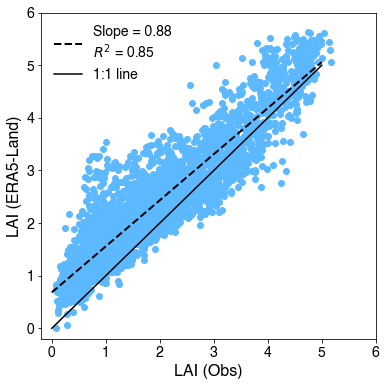

In [209]:
nn = np.where((~np.isnan(lai_obs_regrid_1d)) & (~np.isnan(lai_era5_1d)))[0]
X = sm.add_constant(lai_obs_regrid_1d[nn])
mdl = sm.OLS(lai_era5_1d[nn], X).fit()
mdl.summary()

x1 = 0
x2 = 5

plt.figure(figsize=(6,6))
plt.xlim([-.2, 6])
plt.ylim([-.2, 6])
plt.scatter(lai_obs_regrid_1d,lai_era5_1d, c='#5cb8ff')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', lw=2, label='Slope = %.2f\n$R^2$ = %.2f'%(mdl.params[1], mdl.rsquared))
plt.plot([0,5], [0, 5], '-k', label='1:1 line')
plt.xlabel('LAI (Obs)', fontsize=16)
plt.ylabel('LAI (ERA5-Land)', fontsize=16)
plt.legend(prop={'size': 14}, frameon=False)

# plt.savefig('lai-obs-vs-lai-era5.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


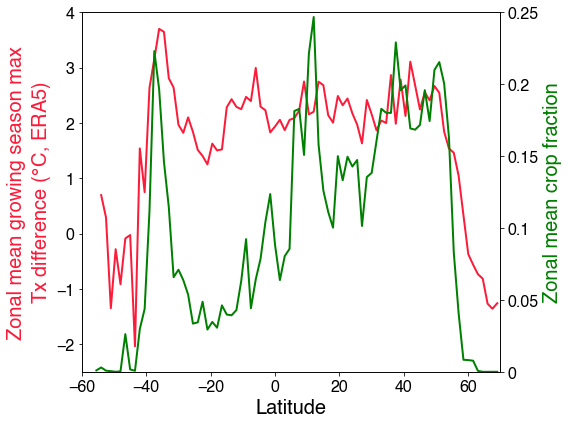

In [210]:
fig, ax = plt.subplots(figsize=(8,6))

lat1 = -60
lat2 = 70

lat1_ind = np.where(abs(regridMesh['lat']-lat1) == min(abs(regridMesh['lat']-lat1)))[0][0]
lat2_ind = np.where(abs(regridMesh['lat']-lat2) == min(abs(regridMesh['lat']-lat2)))[0][0]

zonal_mean_crop = np.nanmean(crop_all_area_regrid[lat1_ind:lat2_ind][:], axis=1)
zonal_mean_bias = np.nanmean(yearly_tasmax_grow_max_bias_mean[lat1_ind:lat2_ind][:], axis=1)

plt.plot(regridMesh['lat'][lat1_ind:lat2_ind][:], zonal_mean_bias, c='#fc1c3a', lw=2)
plt.ylabel('Zonal mean growing season max\nTx difference ($\degree$C, ERA5)', fontsize=20, c='#fc1c3a')
plt.xlabel('Latitude', fontsize=20)
plt.yticks([-2, -1, 0, 1, 2, 3, 4], fontsize=16)

plt.xticks(np.arange(lat1, lat2+1, 20), fontsize=16)
plt.xlim([-60, 70])
plt.ylim([-2.5, 4])

ax0_2 = ax.twinx()

ax0_2.plot(regridMesh['lat'][lat1_ind:lat2_ind][:], zonal_mean_crop, c='g', lw=2)
ax0_2.set_ylabel('Zonal mean crop fraction', fontsize=20, c='g')
ax0_2.set_ylim([0, .25])
ax0_2.set_yticklabels([0, .05, .1, .15, .2, .25], fontsize=16)
plt.yticks(fontsize=16)


# X = sm.add_constant(zonal_mean_crop[zonal_mean_crop>0.05])
# mdl = sm.OLS(zonal_mean_bias[zonal_mean_crop>0.05], X).fit()

# ax[1].scatter(np.nanmean(crop_all_area_regrid[10:-10][:], axis=1), np.nanmean(yearly_tasmax_grow_max_bias_mean[10:-10][:], axis=1), c='#5cb8ff')
# ax[1].plot([0.05, .25], [mdl.params[0]+mdl.params[1]*.05, mdl.params[0]+mdl.params[1]*.25], '--k', lw=2, label='p = 0.18')

# ax[1].set_ylabel('Zonal mean growing season max\nTx difference ($\degree$C, ERA5)', fontsize=20)
# ax[1].set_xlabel('Zonal mean crop fraction', fontsize=20)


# ax[1].set_yticks([-2, -1, 0, 1, 2, 3, 4])
# ax[1].set_yticklabels([-2, -1, 0, 1, 2, 3, 4], fontsize=16)
# ax[1].set_xticks([0, .05, .1, .15, .2, .25])
# ax[1].set_xticklabels([0, .05, .1, .15, .2, .25], fontsize=16)
# plt.legend(prop={'size': 14}, frameon=False)

plt.tight_layout()

# plt.savefig('temp-bias-lat.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

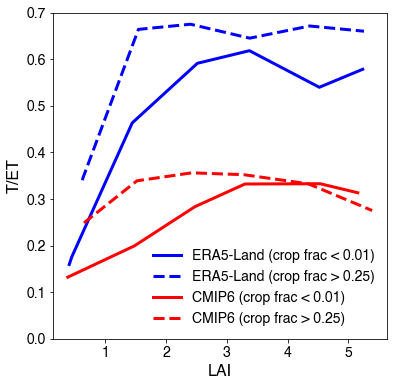

In [211]:

crop_ind_no_crop = np.where((crop_all_area_regrid_1d < 0.01))[0]
crop_ind_high_crop = np.where((crop_all_area_regrid_1d > .25))[0]

cmip6_lai_grow_1d = np.nanmean(np.nanmean(cmip6_lai_grow.lai_grow_mean.values, axis=1), axis=0)
cmip6_lai_grow_1d = cmip6_lai_grow_1d.reshape([cmip6_lai_grow_1d.size])

cmip6_t_et_grow_1d = np.nanmean(np.nanmean(cmip6_t_et_grow.t_et_grow_mean, axis=1), axis=0)
cmip6_t_et_grow_1d = cmip6_t_et_grow_1d.reshape([cmip6_t_et_grow_1d.size])

era5_t_et_1d = np.nanmean(era5_t_et.t_et_grow_mean.values, axis=0)
era5_t_et_1d = era5_t_et_1d.reshape([era5_t_et_1d.size])

era5_lai_1d = np.nanmean(era5_lai_grow_regrid.lai_grow_mean.values, axis=0)
era5_lai_1d = era5_lai_1d.reshape([era5_lai_1d.size])

era5_lai_bins_no_crop = []
era5_t_et_bins_no_crop = []

cmip6_lai_bins_no_crop = []
cmip6_t_et_bins_no_crop = []


era5_lai_bins_high_crop = []
era5_t_et_bins_high_crop = []

cmip6_lai_bins_high_crop = []
cmip6_t_et_bins_high_crop = []

for b in range(7):
    if b == 0:
        ind_era5_no_crop = np.where(era5_lai_1d[crop_ind_no_crop] < 1)[0]
        ind_cmip6_no_crop = np.where(cmip6_lai_grow_1d[crop_ind_no_crop] < 1)[0]
        
        ind_era5_high_crop = np.where(era5_lai_1d[crop_ind_high_crop] < 1)[0]
        ind_cmip6_high_crop = np.where(cmip6_lai_grow_1d[crop_ind_high_crop] < 1)[0]
    else:
        ind_era5_no_crop = np.where((era5_lai_1d[crop_ind_no_crop] > (b-1)) & (era5_lai_1d[crop_ind_no_crop] < b))[0]
        ind_cmip6_no_crop = np.where((cmip6_lai_grow_1d[crop_ind_no_crop] > (b-1)) & (cmip6_lai_grow_1d[crop_ind_no_crop] < b))[0]
        
        ind_era5_high_crop = np.where((era5_lai_1d[crop_ind_high_crop] > (b-1)) & (era5_lai_1d[crop_ind_high_crop] < b))[0]
        ind_cmip6_high_crop = np.where((cmip6_lai_grow_1d[crop_ind_high_crop] > (b-1)) & (cmip6_lai_grow_1d[crop_ind_high_crop] < b))[0]

    era5_lai_bins_no_crop.append(np.nanmean(era5_lai_1d[crop_ind_no_crop][ind_era5_no_crop]))
    era5_t_et_bins_no_crop.append(np.nanmean(era5_t_et_1d[crop_ind_no_crop][ind_era5_no_crop]))

    cmip6_lai_bins_no_crop.append(np.nanmean(cmip6_lai_grow_1d[crop_ind_no_crop][ind_cmip6_no_crop]))
    cmip6_t_et_bins_no_crop.append(np.nanmean(cmip6_t_et_grow_1d[crop_ind_no_crop][ind_cmip6_no_crop]))
    
    
    era5_lai_bins_high_crop.append(np.nanmean(era5_lai_1d[crop_ind_high_crop][ind_era5_high_crop]))
    era5_t_et_bins_high_crop.append(np.nanmean(era5_t_et_1d[crop_ind_high_crop][ind_era5_high_crop]))

    cmip6_lai_bins_high_crop.append(np.nanmean(cmip6_lai_grow_1d[crop_ind_high_crop][ind_cmip6_high_crop]))
    cmip6_t_et_bins_high_crop.append(np.nanmean(cmip6_t_et_grow_1d[crop_ind_high_crop][ind_cmip6_high_crop]))
    
plt.figure(figsize=(6,6))
plt.ylim([0,.7])
plt.plot(era5_lai_bins_no_crop, era5_t_et_bins_no_crop, 'b-', lw=3, label='ERA5-Land (crop frac < 0.01)')
plt.plot(era5_lai_bins_high_crop, era5_t_et_bins_high_crop, 'b--', lw=3, label='ERA5-Land (crop frac > 0.25)')

plt.plot(cmip6_lai_bins_no_crop, cmip6_t_et_bins_no_crop, 'r-', lw=3, label='CMIP6 (crop frac < 0.01)')
plt.plot(cmip6_lai_bins_high_crop, cmip6_t_et_bins_high_crop, 'r--', lw=3, label='CMIP6 (crop frac > 0.25)')
plt.xlabel('LAI', fontsize=16)
plt.ylabel('T/ET', fontsize=16)
plt.legend(prop={'size': 14}, frameon=False)
# plt.savefig('t-et-vs-lai.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

Text(0, 0.5, 'Growing season max\nTx difference ($\\degree$C, ERA5)')

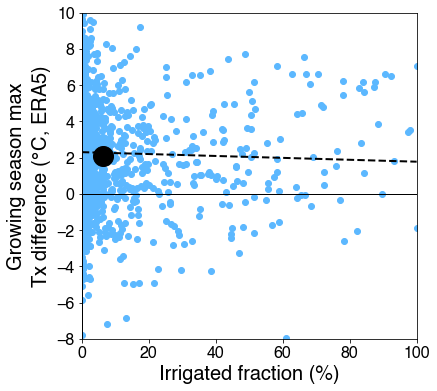

In [212]:
nn = np.where((~np.isnan(irrigation_data_regrid_1d)) & (~np.isnan(yearly_tasmax_grow_max_bias_mean_1d)) & (irrigation_data_regrid_1d > 0))[0]
X = sm.add_constant(irrigation_data_regrid_1d[nn])
mdl_irr_frac = sm.OLS(yearly_tasmax_grow_max_bias_mean_1d[nn], X).fit()

x1 = 0
x2 = 1
plt.figure(figsize=(6,6))
plt.xlim([0, 1])
plt.ylim([-8, 10])
plt.scatter(irrigation_data_regrid_1d, yearly_tasmax_grow_max_bias_mean_1d, c='#5cb8ff')
plt.plot(np.nanmean(irrigation_data_regrid_1d), np.nanmean(yearly_tasmax_grow_max_bias_mean_1d), 'o', markersize=20, color='k')
plt.plot([x1, x2], [mdl_irr_frac.params[0]+x1*mdl_irr_frac.params[1], mdl_irr_frac.params[0]+x2*mdl_irr_frac.params[1]], '--k', lw=2)
plt.plot([0,1], [0,0], '-k', lw=1)
plt.plot([0,0], [-8,10], '-k', lw=1)
plt.xlabel('Irrigated fraction (%)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().set_xticklabels(['0', '20', '40', '60', '80', '100'])
plt.ylabel('Growing season max\nTx difference ($\degree$C, ERA5)', fontsize=20)

# plt.savefig('tx-bias-irr.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

-0.887288972638219


Text(0, 0.5, 'Growing season max\nTx difference ($\\degree$C, ERA5)')

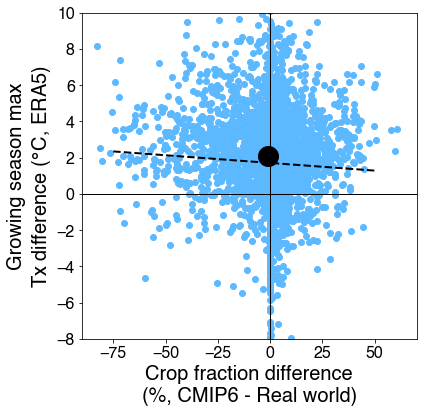

In [213]:
nn = np.where((~np.isnan(cmip6_ha_bias_mean_1d)) & (~np.isnan(yearly_tasmax_grow_max_bias_mean_1d)))[0]
X = sm.add_constant(cmip6_ha_bias_mean_1d[nn])
mdl_crop_frac_bias = sm.OLS(yearly_tasmax_grow_max_bias_mean_1d[nn], X).fit()

print(np.nanmean(cmip6_ha_bias_mean_1d))

x1 = -75
x2 = 50
plt.figure(figsize=(6,6))
plt.xlim([-90, 70])
plt.ylim([-8, 10])
plt.scatter(cmip6_ha_bias_mean_1d, yearly_tasmax_grow_max_bias_mean_1d, c='#5cb8ff')
plt.plot(np.nanmean(cmip6_ha_bias_mean_1d), np.nanmean(yearly_tasmax_grow_max_bias_mean_1d), 'o', markersize=20, color='k')
plt.plot([x1, x2], [mdl_crop_frac_bias.params[0]+x1*mdl_crop_frac_bias.params[1], mdl_crop_frac_bias.params[0]+x2*mdl_crop_frac_bias.params[1]], '--k', lw=2)
plt.plot([-100,100], [0,0], '-k', lw=1)
plt.plot([0,0], [-8,10], '-k', lw=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Crop fraction difference\n(%, CMIP6 - Real world)', fontsize=20)
plt.ylabel('Growing season max\nTx difference ($\degree$C, ERA5)', fontsize=20)

# plt.savefig('crop-frac-bias-cmip6.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [214]:
irrigation_data_regrid_1d = irrigation_data_regrid.reshape([irrigation_data_regrid.size,1])

In [215]:
ind_pr_tran = np.where((~np.isnan(yearly_pr_grow_bias_mean_1d)) & (~np.isnan(yearly_tran_grow_bias_mean_1d)))[0]
yearly_tran_grow_bias_pr_resid_mean_1d = np.full(yearly_tran_grow_bias_mean_1d.shape, np.nan)

X = sm.add_constant(yearly_pr_grow_bias_mean_1d[ind_pr_tran])
mdl_tran_grow_bias_resid = sm.OLS(yearly_tran_grow_bias_mean_1d[ind_pr_tran], X).fit()

yearly_tran_grow_bias_pr_resid_mean_1d[ind_pr_tran,0] = mdl_tran_grow_bias_resid.resid

In [216]:
ind_pr_lai = np.where((~np.isnan(yearly_pr_grow_bias_mean_1d)) & (~np.isnan(yearly_lai_grow_bias_mean_1d)))[0]
yearly_lai_grow_bias_pr_resid_mean_1d = np.full(yearly_lai_grow_bias_mean_1d.shape, np.nan)

X = sm.add_constant(yearly_pr_grow_bias_mean_1d[ind_pr_lai])
mdl_lai_grow_bias_resid = sm.OLS(yearly_lai_grow_bias_mean_1d[ind_pr_lai], X).fit()

yearly_lai_grow_bias_pr_resid_mean_1d[ind_pr_lai,0] = mdl_lai_grow_bias_resid.resid

In [217]:
bins = [0,.01,.05,.1,.2,.3, .4, .5, .6, .7, .8]
binned_tx_max_bias = []
binned_tx_max_bias_no_irr = []
binned_tx_max_bias_high_irr = []
binned_tx_max_bias_data = []
binned_tx_max_bias_std = []
binned_tx_max_bias_per_model = []
binned_tx_max_bias_data_per_model = []

binned_tx_mean_bias = []
binned_tx_mean_bias_no_irr = []
binned_tx_mean_bias_high_irr = []

binned_tx_max_bias_cpc = []
binned_tx_max_bias_cpc_no_irr = []
binned_tx_max_bias_cpc_high_irr = []
binned_tx_max_bias_cpc_per_model = []
binned_tx_max_bias_cpc_data_per_model = []

binned_tran_bias = []
binned_tran_bias_no_irr = []
binned_tran_bias_high_irr = []

binned_tran_bias_pr_resid = []
binned_tran_bias_pr_resid_no_irr = []
binned_tran_bias_pr_resid_high_irr = []

binned_lai_bias_pr_resid = []
binned_lai_bias_pr_resid_no_irr = []
binned_lai_bias_pr_resid_high_irr = []

binned_tran_bias_rel_gridcell = []
binned_tran_bias_rel_global_mean = []
binned_tran_bias_gldas = []
binned_tran_bias_per_model = []

binned_cmip6_mean_t_et = []
binned_era5_t_et = []
binned_gldas_t_et = []

binned_t_et_bias = []
binned_t_et_bias_per_model = []
binned_t_et_bias_gldas = []
binned_t_et_bias_gldas_per_model = []

binned_t_pr_bias = []
binned_t_pr_bias_no_irr = []
binned_t_pr_bias_high_irr = []

binned_evap_canopy_bias = []
binned_evap_canopy_bias_rel_gridcell = []
binned_evap_canopy_bias_rel_global_mean = []
binned_canopy_evap_bias_gldas = []
binned_evap_canopy_bias_per_model = []

binned_evap_soil_bias = []
binned_evap_soil_bias_rel_gridcell = []
binned_evap_soil_bias_rel_global_mean = []
binned_soil_evap_bias_gldas = []
binned_evap_soil_bias_per_model = []

binned_pr_bias = []
binned_pr_bias_rel_gridcell = []
binned_pr_bias_rel_global_mean = []
binned_pr_bias_per_model = []
binned_pr_gpcp_bias = []
binned_pr_gpcp_bias_per_model = []

binned_lai_bias = []
binned_lai_bias_data = []
binned_lai_bias_per_model = []
binned_lai_obs_bias = []
binned_lai_obs_bias_per_model = []

binned_et_bias = []
binned_et_bias_gldas = []

binned_normalized_tran_era5 = []
binned_normalized_tran_cmip6 = []
binned_normalized_tran_cmip6_per_model = []


for b,bcur in enumerate(bins):
    if b == len(bins)-1:
        ind = np.where((~np.isnan(crop_all_area_regrid_1d)) & (crop_all_area_regrid_1d >= bcur))[0]
        ind_no_irr = np.where((~np.isnan(crop_all_area_regrid_1d)) & (crop_all_area_regrid_1d >= bcur) & (irrigation_data_regrid_1d <= .01))[0]
        ind_high_irr = np.where((~np.isnan(crop_all_area_regrid_1d)) & (crop_all_area_regrid_1d >= bcur) & (irrigation_data_regrid_1d > 0.2))[0]
    else:
        ind = np.where((~np.isnan(crop_all_area_regrid_1d)) & (crop_all_area_regrid_1d >= bcur) & (crop_all_area_regrid_1d < bins[b+1]))[0]
        ind_no_irr = np.where((~np.isnan(crop_all_area_regrid_1d)) & (crop_all_area_regrid_1d >= bcur) & (crop_all_area_regrid_1d < bins[b+1]) & (irrigation_data_regrid_1d <= .01))[0]
        ind_high_irr = np.where((~np.isnan(crop_all_area_regrid_1d)) & (crop_all_area_regrid_1d >= bcur) & (crop_all_area_regrid_1d < bins[b+1]) & (irrigation_data_regrid_1d > 0.2))[0]
    
    binned_tx_max_bias.append(np.nanmean(yearly_tasmax_grow_max_bias_mean_1d[ind]))
    binned_tx_max_bias_no_irr.append(np.nanmean(yearly_tasmax_grow_max_bias_mean_1d[ind_no_irr]))
    binned_tx_max_bias_high_irr.append(np.nanmean(yearly_tasmax_grow_max_bias_mean_1d[ind_high_irr]))
    
    binned_tx_mean_bias.append(np.nanmean(yearly_tasmax_grow_mean_bias_mean_1d[ind]))
    binned_tx_mean_bias_no_irr.append(np.nanmean(yearly_tasmax_grow_mean_bias_mean_1d[ind_no_irr]))
    binned_tx_mean_bias_high_irr.append(np.nanmean(yearly_tasmax_grow_mean_bias_mean_1d[ind_high_irr]))
    
    binned_tx_max_bias_data.append(yearly_tasmax_grow_max_bias_mean_1d[ind])
    binned_tx_max_bias_std.append(np.nanstd(yearly_tasmax_grow_max_bias_mean_1d[ind]))
    binned_tx_max_bias_cpc.append(np.nanmean(yearly_tasmax_grow_max_bias_cpc_mean_1d[ind]))
    binned_tx_max_bias_cpc_no_irr.append(np.nanmean(yearly_tasmax_grow_max_bias_cpc_mean_1d[ind_no_irr]))
    binned_tx_max_bias_cpc_high_irr.append(np.nanmean(yearly_tasmax_grow_max_bias_cpc_mean_1d[ind_high_irr]))
    
    binned_tran_bias.append(np.nanmean(yearly_tran_grow_bias_mean_1d[ind]))
    binned_tran_bias_no_irr.append(np.nanmean(yearly_tran_grow_bias_mean_1d[ind_no_irr]))
    binned_tran_bias_high_irr.append(np.nanmean(yearly_tran_grow_bias_mean_1d[ind_high_irr]))
    
    binned_tran_bias_pr_resid.append(np.nanmean(yearly_tran_grow_bias_pr_resid_mean_1d[ind]))
    binned_tran_bias_pr_resid_no_irr.append(np.nanmean(yearly_tran_grow_bias_pr_resid_mean_1d[ind_no_irr]))
    binned_tran_bias_pr_resid_high_irr.append(np.nanmean(yearly_tran_grow_bias_pr_resid_mean_1d[ind_high_irr]))
    
    binned_lai_bias_pr_resid.append(np.nanmean(yearly_lai_grow_bias_pr_resid_mean_1d[ind]))
    binned_lai_bias_pr_resid_no_irr.append(np.nanmean(yearly_lai_grow_bias_pr_resid_mean_1d[ind_no_irr]))
    binned_lai_bias_pr_resid_high_irr.append(np.nanmean(yearly_lai_grow_bias_pr_resid_mean_1d[ind_high_irr]))
           
    binned_evap_canopy_bias.append(np.nanmean(yearly_evap_from_canopy_grow_bias_mean_1d[ind]))
    binned_evap_soil_bias.append(np.nanmean(yearly_evap_from_soil_grow_bias_mean_1d[ind]))
    binned_et_bias.append(np.nanmean(yearly_et_grow_bias_mean_1d[ind]))
    
    binned_pr_bias_rel_gridcell.append(np.nanmean(yearly_pr_grow_bias_mean_rel_gridcell_1d[ind]))
    binned_tran_bias_rel_gridcell.append(np.nanmean(yearly_tran_grow_bias_mean_rel_gridcell_1d[ind]))
    binned_evap_canopy_bias_rel_gridcell.append(np.nanmean(yearly_evap_from_canopy_grow_bias_mean_rel_gridcell_1d[ind]))
    binned_evap_soil_bias_rel_gridcell.append(np.nanmean(yearly_evap_from_soil_grow_bias_mean_rel_gridcell_1d[ind]))
    
    binned_pr_bias_rel_global_mean.append(np.nanmean(yearly_pr_grow_bias_mean_rel_global_mean_1d[ind]))
    binned_tran_bias_rel_global_mean.append(np.nanmean(yearly_tran_grow_bias_mean_rel_global_mean_1d[ind]))
    binned_evap_canopy_bias_rel_global_mean.append(np.nanmean(yearly_evap_from_canopy_grow_bias_mean_rel_global_mean_1d[ind]))
    binned_evap_soil_bias_rel_global_mean.append(np.nanmean(yearly_evap_from_soil_grow_bias_mean_rel_global_mean_1d[ind]))
    
    binned_tran_bias_gldas.append(np.nanmean(yearly_tran_grow_bias_gldas_mean_1d[ind]))
    binned_canopy_evap_bias_gldas.append(np.nanmean(yearly_canopy_evap_grow_bias_gldas_mean_1d[ind]))
    binned_soil_evap_bias_gldas.append(np.nanmean(yearly_soil_evap_grow_bias_gldas_mean_1d[ind]))
    binned_et_bias_gldas.append(np.nanmean(yearly_et_grow_bias_gldas_mean_1d[ind]))
    
    binned_pr_bias.append(np.nanmean(yearly_pr_grow_bias_mean_1d[ind]))
    binned_pr_gpcp_bias.append(np.nanmean(yearly_pr_grow_bias_gpcp_mean_1d[ind]))
    binned_lai_bias.append(np.nanmean(yearly_lai_grow_bias_mean_1d[ind]))
    binned_lai_bias_data.append(yearly_lai_grow_bias_mean_1d[ind])
    binned_lai_obs_bias.append(np.nanmean(lai_grow_obs_bias_mean_1d[ind]))
    
    binned_cmip6_mean_t_et.append(np.nanmean(cmip6_t_et_grow_mean_1d[ind]))
    binned_era5_t_et.append(np.nanmean(era5_t_et_mean_1d[ind]))
    binned_t_et_bias.append(np.nanmean(cmip6_t_et_grow_bias_mean_1d[ind]))
    binned_t_et_bias_gldas.append(np.nanmean(cmip6_t_et_grow_bias_gldas_mean_1d[ind]))
    
    binned_t_pr_bias.append(np.nanmean(cmip6_t_pr_grow_bias_mean_1d[ind]))
    binned_t_pr_bias_no_irr.append(np.nanmean(cmip6_t_pr_grow_bias_mean_1d[ind_no_irr]))
    binned_t_pr_bias_high_irr.append(np.nanmean(cmip6_t_pr_grow_bias_mean_1d[ind_high_irr]))
    
    
    binned_gldas_t_et.append(np.nanmean(gldas_t_et_mean_1d[ind]))
    
    binned_normalized_tran_era5.append(np.nanmean(era5_normalized_tran_1d[ind]))
    binned_normalized_tran_cmip6.append(np.nanmean(cmip6_normalized_tran_mean_1d[ind]))
    
    
    for m in range(tran_bias_time_mean_2d.shape[0]):
        if b == 0:
            binned_tran_bias_per_model.append([])
            binned_evap_canopy_bias_per_model.append([])
            binned_evap_soil_bias_per_model.append([])
            binned_pr_bias_per_model.append([])
            binned_pr_gpcp_bias_per_model.append([])
            binned_tx_max_bias_per_model.append([])
            binned_tx_max_bias_cpc_per_model.append([])
            binned_lai_bias_per_model.append([])
            binned_lai_obs_bias_per_model.append([])
            binned_t_et_bias_per_model.append([])
            binned_t_et_bias_gldas_per_model.append([])
            binned_normalized_tran_cmip6_per_model.append([])
            binned_tx_max_bias_data_per_model.append([])
            binned_tx_max_bias_cpc_data_per_model.append([])
            
        binned_tran_bias_per_model[m].append(np.nanmean(tran_bias_time_mean_2d[m,ind]))
        binned_evap_canopy_bias_per_model[m].append(np.nanmean(evap_canopy_bias_time_mean_2d[m,ind]))
        binned_evap_soil_bias_per_model[m].append(np.nanmean(evap_soil_bias_time_mean_2d[m,ind]))
        binned_pr_bias_per_model[m].append(np.nanmean(pr_bias_time_mean_2d[m,ind]))
        binned_pr_gpcp_bias_per_model[m].append(np.nanmean(pr_bias_gpcp_time_mean_2d[m,ind]))
        binned_tx_max_bias_per_model[m].append(np.nanmean(tasmax_grow_max_bias_time_mean_2d[m,ind]))
        binned_tx_max_bias_cpc_per_model[m].append(np.nanmean(tasmax_grow_max_bias_cpc_time_mean_2d[m,ind]))
        binned_lai_bias_per_model[m].append(np.nanmean(lai_grow_bias_time_mean_2d[m,ind]))
        binned_lai_obs_bias_per_model[m].append(np.nanmean(lai_grow_obs_bias_time_mean_2d[m,ind]))
        binned_t_et_bias_per_model[m].append(np.nanmean(cmip6_t_et_grow_bias_time_mean_2d[m,ind]))
        binned_t_et_bias_gldas_per_model[m].append(np.nanmean(cmip6_t_et_grow_bias_gldas_time_mean_2d[m,ind]))
        binned_normalized_tran_cmip6_per_model[m].append(np.nanmean(cmip6_normalized_tran_mean_2d[m,ind]))
        binned_tx_max_bias_data_per_model[m].append(tasmax_grow_max_bias_time_mean_2d[m,ind])
        binned_tx_max_bias_cpc_data_per_model[m].append(tasmax_grow_max_bias_cpc_time_mean_2d[m,ind])


binned_lai_bias_per_model = np.array(binned_lai_bias_per_model)
binned_lai_obs_bias_per_model = np.array(binned_lai_obs_bias_per_model)
binned_lai_bias_data = np.array(binned_lai_bias_data)
binned_normalized_tran_cmip6_per_model = np.array(binned_normalized_tran_cmip6_per_model)

binned_tx_max_bias_data = np.array(binned_tx_max_bias_data)
binned_tx_max_bias_data_per_model = np.array(binned_tx_max_bias_data_per_model)
binned_tx_max_bias_cpc_data_per_model = np.array(binned_tx_max_bias_cpc_data_per_model)

In [218]:
np.nanmean(binned_lai_bias_data[-2]) - np.nanmean(binned_lai_bias_data[-1])

0.11626351132967247

In [219]:
# compare 0.7 lai diff to 0.8
scipy.stats.ks_2samp(np.array([x[0] for x in binned_lai_bias_data[-2]]), np.array([x[0] for x in binned_lai_bias_data[-1]]))

KstestResult(statistic=0.11170024743725698, pvalue=0.4857919996959158)

In [220]:
np.nanmean(binned_lai_bias_data[-2]) - np.nanmean(binned_lai_bias_data[-3])

0.10342181805994669

In [221]:
# compare 0.7 lai diff to 0.6
scipy.stats.ks_2samp(np.array([x[0] for x in binned_lai_bias_data[-2]]), np.array([x[0] for x in binned_lai_bias_data[-3]]))

KstestResult(statistic=0.10592007328523989, pvalue=0.4125838850342549)

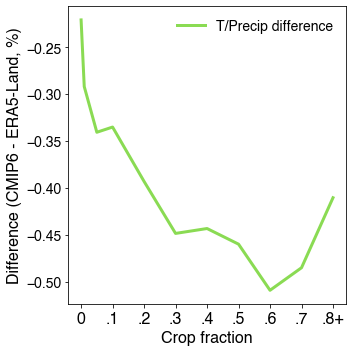

In [222]:
# plt.plot(bins, binned_t_pr_bias)

plt.figure(figsize=(5,5))

plt.plot(bins, binned_t_pr_bias, '-', label='T/Precip difference', lw=3, c='#8adb53')
# plt.plot(bins, binned_t_pr_bias_high_irr, '--', label='T/Precip difference', lw=3, c='#8adb53')
plt.xlabel('Crop fraction', fontsize=16)
plt.xticks(np.arange(0, .81, .1))
plt.gca().set_xticklabels(['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+'], fontsize=16)
plt.ylabel('Difference (CMIP6 - ERA5-Land, %)', fontsize=16)
plt.legend(prop={'size': 14}, frameon=False)


plt.tight_layout()

# plt.savefig('t-div-p-diff.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

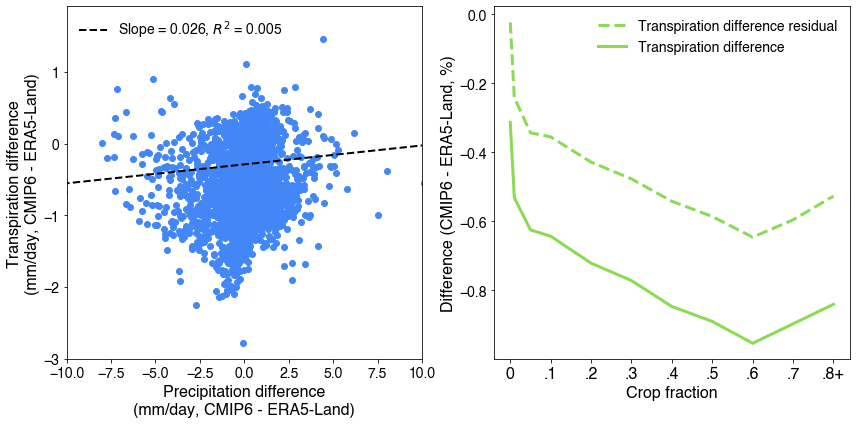

In [223]:


x1 = -20
x2 = 10

fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_xlim([-10,10])
# ax[0].set_ylim([-1,0])
ax[0].scatter(yearly_pr_grow_bias_mean_1d[ind_pr_tran], yearly_tran_grow_bias_mean_1d[ind_pr_tran], c='#4287f5')
ax[0].plot([x1, x2], [mdl_tran_grow_bias_resid.params[0]+x1*mdl_tran_grow_bias_resid.params[1], mdl_tran_grow_bias_resid.params[0]+x2*mdl_tran_grow_bias_resid.params[1]], '--k', lw=2, \
          label='Slope = %.3f, $R^2$ = %.3f'%(mdl_tran_grow_bias_resid.params[1], mdl_tran_grow_bias_resid.rsquared))
ax[0].set_xlabel('Precipitation difference\n(mm/day, CMIP6 - ERA5-Land)', fontsize=16)
ax[0].set_ylabel('Transpiration difference\n(mm/day, CMIP6 - ERA5-Land)', fontsize=16)
ax[0].legend(prop={'size': 14}, frameon=False)

ax[1].plot(bins, binned_tran_bias_pr_resid, '--', label='Transpiration difference residual', lw=3, c='#8adb53')
ax[1].plot(bins, binned_tran_bias, label='Transpiration difference', lw=3, c='#8adb53')
ax[1].set_xlabel('Crop fraction', fontsize=16)
ax[1].set_xticks(np.arange(0, .81, .1))
ax[1].set_xticklabels(['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+'], fontsize=16)
ax[1].set_ylabel('Difference (CMIP6 - ERA5-Land, %)', fontsize=16)
ax[1].legend(prop={'size': 14}, frameon=False)

plt.tight_layout()

plt.savefig('trans-pr-resid.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

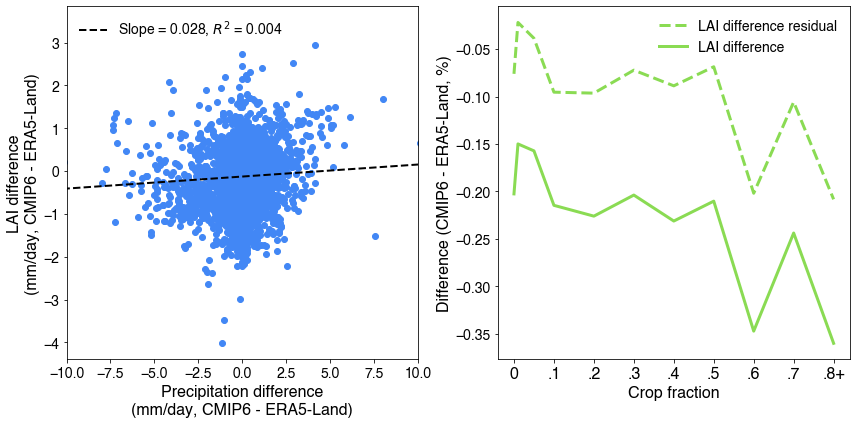

In [224]:


x1 = -20
x2 = 10

fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_xlim([-10,10])
# ax[0].set_ylim([-1,0])
ax[0].scatter(yearly_pr_grow_bias_mean_1d[ind_pr_lai], yearly_lai_grow_bias_mean_1d[ind_pr_lai], c='#4287f5')
ax[0].plot([x1, x2], [mdl_lai_grow_bias_resid.params[0]+x1*mdl_lai_grow_bias_resid.params[1], mdl_lai_grow_bias_resid.params[0]+x2*mdl_lai_grow_bias_resid.params[1]], '--k', lw=2, \
          label='Slope = %.3f, $R^2$ = %.3f'%(mdl_lai_grow_bias_resid.params[1], mdl_lai_grow_bias_resid.rsquared))
ax[0].set_xlabel('Precipitation difference\n(mm/day, CMIP6 - ERA5-Land)', fontsize=16)
ax[0].set_ylabel('LAI difference\n(mm/day, CMIP6 - ERA5-Land)', fontsize=16)
ax[0].legend(prop={'size': 14}, frameon=False)

ax[1].plot(bins, binned_lai_bias_pr_resid, '--', label='LAI difference residual', lw=3, c='#8adb53')
ax[1].plot(bins, binned_lai_bias, label='LAI difference', lw=3, c='#8adb53')
ax[1].set_xlabel('Crop fraction', fontsize=16)
ax[1].set_xticks(np.arange(0, .81, .1))
ax[1].set_xticklabels(['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+'], fontsize=16)
ax[1].set_ylabel('Difference (CMIP6 - ERA5-Land, %)', fontsize=16)
ax[1].legend(prop={'size': 14}, frameon=False)

plt.tight_layout()

plt.savefig('lai-pr-resid.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [225]:
# is non cropped land sig different from 0
np.nanmean(binned_tx_max_bias_data[0])
nn = np.where(~np.isnan(binned_tx_max_bias_data[0]))[0]
scipy.stats.ttest_1samp(binned_tx_max_bias_data[0][nn], 0)

Ttest_1sampResult(statistic=array([21.45848571]), pvalue=array([1.32514048e-95]))

In [226]:
# is non cropped land sig different from 0
np.nanmean(binned_tx_max_bias_data[-1])
nn = np.where(~np.isnan(binned_tx_max_bias_data[0]))[0]
scipy.stats.ttest_1samp(binned_tx_max_bias_data[0][nn], 0)

Ttest_1sampResult(statistic=array([21.45848571]), pvalue=array([1.32514048e-95]))

In [227]:
med_diff_from_bin1_era5 = []
pval_diff_from_bin1_era5 = []
med_diff_from_bin0_era5 = []
pval_diff_from_bin0_era5 = []

med_diff_from_bin1_cpc = []
pval_diff_from_bin1_cpc = []
med_diff_from_bin0_cpc = []
pval_diff_from_bin0_cpc = []


for b in range(len(bins)):
    med_diff_from_bin1_era5.append([])
    med_diff_from_bin0_era5.append([])
    pval_diff_from_bin1_era5.append([])
    pval_diff_from_bin0_era5.append([])
    
    med_diff_from_bin1_cpc.append([])
    med_diff_from_bin0_cpc.append([])
    pval_diff_from_bin1_cpc.append([])
    pval_diff_from_bin0_cpc.append([])
    
    for m in range(len(cmip6_models)):

        # ERA5
        cur_crop_bins = np.array([y for y in binned_tx_max_bias_data_per_model[m,b]])
        low_crop_bins = np.array([y for y in binned_tx_max_bias_data_per_model[m,1]])
        no_crop_bins = np.array([y for y in binned_tx_max_bias_data_per_model[m,0]])

        stat, pval_cur_bin1 = scipy.stats.ks_2samp(low_crop_bins, cur_crop_bins)
        stat, pval_cur_bin0 = scipy.stats.ks_2samp(no_crop_bins, cur_crop_bins)

        med_diff_from_bin1_era5[b].append(np.nanmedian(cur_crop_bins)-np.nanmedian(low_crop_bins))
        pval_diff_from_bin1_era5[b].append(pval_cur_bin1)
        med_diff_from_bin0_era5[b].append(np.nanmedian(cur_crop_bins)-np.nanmedian(no_crop_bins))
        pval_diff_from_bin0_era5[b].append(pval_cur_bin0)
        
        
        # CPC
        cur_crop_bins = np.array([y for y in binned_tx_max_bias_cpc_data_per_model[m,b]])
        low_crop_bins = np.array([y for y in binned_tx_max_bias_cpc_data_per_model[m,1]])
        no_crop_bins = np.array([y for y in binned_tx_max_bias_cpc_data_per_model[m,0]])

        stat, pval_cur_bin1 = scipy.stats.ks_2samp(low_crop_bins, cur_crop_bins)
        stat, pval_cur_bin0 = scipy.stats.ks_2samp(no_crop_bins, cur_crop_bins)

        med_diff_from_bin1_cpc[b].append(np.nanmedian(cur_crop_bins)-np.nanmedian(low_crop_bins))
        pval_diff_from_bin1_cpc[b].append(pval_cur_bin1)
        med_diff_from_bin0_cpc[b].append(np.nanmedian(cur_crop_bins)-np.nanmedian(no_crop_bins))
        pval_diff_from_bin0_cpc[b].append(pval_cur_bin0)

med_diff_from_bin1_era5 = np.array(med_diff_from_bin1_era5)
med_diff_from_bin0_era5 = np.array(med_diff_from_bin0_era5)
pval_diff_from_bin1_era5 = np.array(pval_diff_from_bin1_era5)
pval_diff_from_bin0_era5 = np.array(pval_diff_from_bin0_era5)

med_diff_from_bin1_cpc = np.array(med_diff_from_bin1_cpc)
med_diff_from_bin0_cpc = np.array(med_diff_from_bin0_cpc)
pval_diff_from_bin1_cpc = np.array(pval_diff_from_bin1_cpc)
pval_diff_from_bin0_cpc = np.array(pval_diff_from_bin0_cpc)

In [228]:
med_diff_high_low = []
pval_diff_high_low = []

med_diff_high_no = []
pval_diff_high_no = []

for m in range(len(cmip6_models)):
#     upper_bins = np.concatenate(np.array([y for y in binned_tx_max_bias_data_per_model[m,-2:]]))
#     lower_bins = np.concatenate(np.array([y for y in binned_tx_max_bias_data_per_model[m,1:2]]))
    
    high_crop_bins = np.array([y for y in binned_tx_max_bias_data_per_model[m,-1]])
    low_crop_bins = np.array([y for y in binned_tx_max_bias_data_per_model[m,1]])
    no_crop_bins = np.array([y for y in binned_tx_max_bias_data_per_model[m,0]])

    stat, pval_high_low_crop = scipy.stats.ks_2samp(low_crop_bins, high_crop_bins)
    stat, pval_high_no_crop = scipy.stats.ks_2samp(no_crop_bins, high_crop_bins)

    med_diff_high_low.append(np.nanmedian(high_crop_bins)-np.nanmedian(low_crop_bins))
    pval_diff_high_low.append(pval_high_low_crop)
    
    med_diff_high_no.append(np.nanmedian(high_crop_bins)-np.nanmedian(no_crop_bins))
    pval_diff_high_no.append(pval_high_no_crop)

med_diff_high_low = np.array(med_diff_high_low)
pval_diff_high_low = np.array(pval_diff_high_low)

med_diff_high_no = np.array(med_diff_high_no)
pval_diff_high_no = np.array(pval_diff_high_no)

In [229]:
n_high_low = np.where((med_diff_high_low>0) & (pval_diff_high_low<=.05))[0]
n_high_no = np.where((med_diff_high_no>0) & (pval_diff_high_no<=.05))[0]
print('high-low',np.nanmedian(med_diff_high_low), len(n_high_low)/len(cmip6_models))
print('high-no',np.nanmedian(med_diff_high_no),len(n_high_no)/len(cmip6_models))

high-low 1.9050391875480077 0.8571428571428571
high-no 2.9802957666316803 1.0


In [230]:
sig_result = np.full([len(bins), len(bins)], np.nan)
for bin1 in range(len(bins)):
    for bin2 in range(len(bins)):
        stat,pval = scipy.stats.ks_2samp(np.array([x[0] for x in binned_tx_max_bias_data[bin1]]), np.array([x[0] for x in binned_tx_max_bias_data[bin2]]))
        if bin2 > bin1:
            if pval <= .05:
                sig_result[bin1, bin2] = 1
            else:
                sig_result[bin1, bin2] = 0

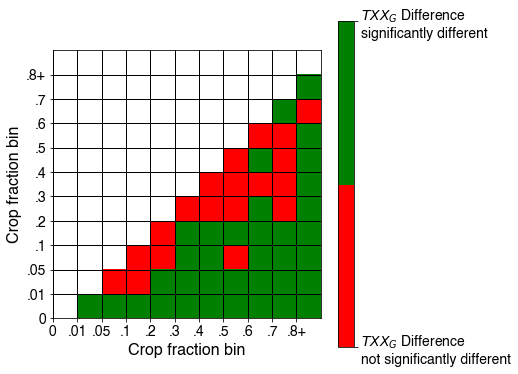

In [231]:
from matplotlib import colors
cmap = colors.ListedColormap(['red', 'green'])
bounds=[0, 0.1, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(6,6))

# make a color bar
img = plt.imshow(sig_result, origin='lower', interpolation='nearest', cmap=cmap, norm=norm)
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1])
cbar.set_ticklabels(['$TXX_G$ Difference\nnot significantly different', '$TXX_G$ Difference\nsignificantly different'])

plt.xticks(np.arange(-.5, 10.5, 1));
plt.gca().set_xticklabels(['0', '.01', '.05', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+']);
plt.xlabel('Crop fraction bin')
plt.yticks(np.arange(-.5, 10.5, 1));
plt.gca().set_yticklabels(['0', '.01', '.05', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+']);
plt.ylabel('Crop fraction bin')

plt.grid(color='k', linestyle='-', linewidth=1)

# plt.savefig('tx-diff-bins-sig-different-grid.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [232]:
t = tasmax_grow_max_bias_time_mean_2d[m,:]


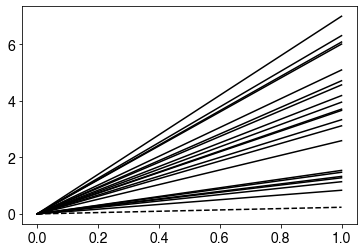

In [233]:
intercept = []
slopes = []
pvals = []

n_sig_slope = 0


plt.figure()

for m in range(len(cmip6_models)):

    t = tasmax_grow_max_bias_time_mean_2d[m,:].reshape([tasmax_grow_max_bias_time_mean_2d[m,:].size,1])
    c = crop_all_area_regrid_1d

    ind_land = np.where((~np.isnan(c)) & (c>=0) & (~np.isnan(t)))[0]
    
    X = sm.add_constant(c[ind_land])
    mdl = sm.OLS(t[ind_land], X).fit()
    
    intercept.append(mdl.params[0])
    slopes.append(mdl.params[1])
    pvals.append(mdl.pvalues[1])
    
    if slopes[m] > 0 and pvals[m] <= .05:
        n_sig_slope += 1
    
    if pvals[m] <= .05:
#         plt.plot([0,1], [intercept[m], intercept[m]+1*slopes[m]], '-k')
        plt.plot([0,1], [0, 1*slopes[m]], '-k')
    else:
        plt.plot([0,1], [0, 1*slopes[m]], '--k')
    
# plt.scatter(c[ind_land], t[ind_land])

In [234]:
n_sig_slope/len(cmip6_models)

0.9523809523809523

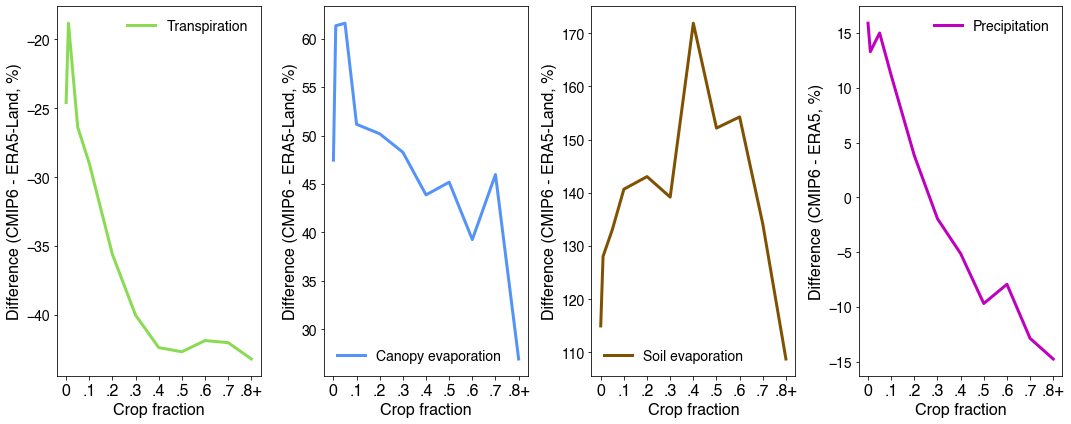

In [235]:
fig, ax = plt.subplots(1,4,figsize=(15,6))
ax[0].plot(bins, binned_tran_bias_rel_gridcell, label='Transpiration', lw=3, c='#8adb53')
ax[0].set_xlabel('Crop fraction', fontsize=16)
ax[0].set_xticks(np.arange(0, .81, .1))
ax[0].set_xticklabels(['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+'], fontsize=16)
ax[0].set_ylabel('Difference (CMIP6 - ERA5-Land, %)', fontsize=16)
ax[0].legend(prop={'size': 14}, frameon=False)


ax[1].plot(bins, binned_evap_canopy_bias_rel_gridcell, label='Canopy evaporation', lw=3, c='#5493f7')
ax[1].set_xlabel('Crop fraction', fontsize=16)
ax[1].set_xticks(np.arange(0, .81, .1))
ax[1].set_xticklabels(['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+'], fontsize=16)
ax[1].set_ylabel('Difference (CMIP6 - ERA5-Land, %)', fontsize=16)
ax[1].legend(prop={'size': 14}, frameon=False)

ax[2].plot(bins, binned_evap_soil_bias_rel_gridcell, label='Soil evaporation', lw=3, c='#805101')
ax[2].set_xlabel('Crop fraction', fontsize=16)
ax[2].set_xticks(np.arange(0, .81, .1))
ax[2].set_xticklabels(['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+'], fontsize=16)
ax[2].set_ylabel('Difference (CMIP6 - ERA5-Land, %)', fontsize=16)
ax[2].legend(prop={'size': 14}, frameon=False)

ax[3].plot(bins, binned_pr_bias_rel_gridcell, label='Precipitation', lw=3, c='m')
ax[3].set_xlabel('Crop fraction', fontsize=16)
ax[3].set_xticks(np.arange(0, .81, .1))
ax[3].set_xticklabels(['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+'], fontsize=16)
ax[3].set_ylabel('Difference (CMIP6 - ERA5, %)', fontsize=16)
ax[3].legend(prop={'size': 14}, frameon=False)

plt.tight_layout()
# plt.savefig('binned-evap-vars-cmip6-era5-rel-gridcell.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


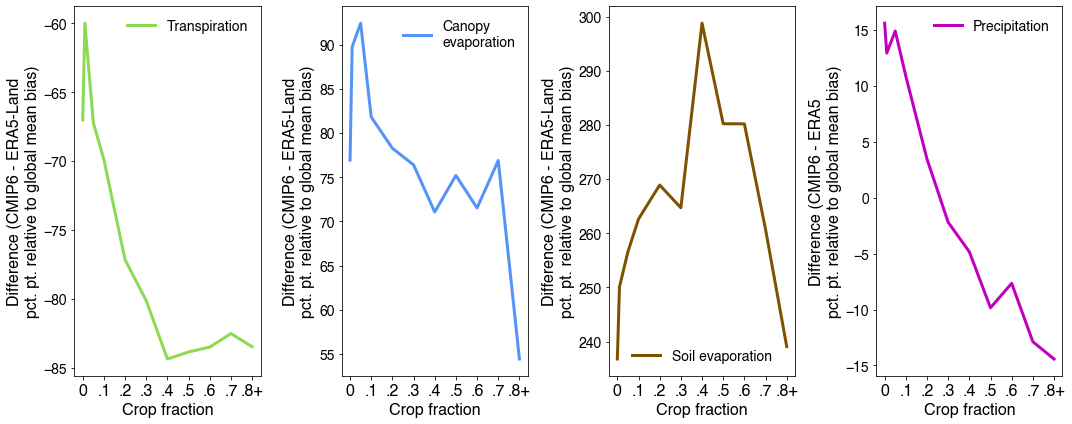

In [236]:
fig, ax = plt.subplots(1,4,figsize=(15,6))
ax[0].plot(bins, binned_tran_bias_rel_global_mean, label='Transpiration', lw=3, c='#8adb53')
ax[0].set_xlabel('Crop fraction', fontsize=16)
ax[0].set_xticks(np.arange(0, .81, .1))
ax[0].set_xticklabels(['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+'], fontsize=16)
ax[0].set_ylabel('Difference (CMIP6 - ERA5-Land\npct. pt. relative to global mean bias)', fontsize=16)
ax[0].legend(prop={'size': 14}, frameon=False)


ax[1].plot(bins, binned_evap_canopy_bias_rel_global_mean, label='Canopy\nevaporation', lw=3, c='#5493f7')
ax[1].set_xlabel('Crop fraction', fontsize=16)
ax[1].set_xticks(np.arange(0, .81, .1))
ax[1].set_xticklabels(['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+'], fontsize=16)
ax[1].set_ylabel('Difference (CMIP6 - ERA5-Land\npct. pt. relative to global mean bias)', fontsize=16)
ax[1].legend(prop={'size': 14}, frameon=False)

ax[2].plot(bins, binned_evap_soil_bias_rel_global_mean, label='Soil evaporation', lw=3, c='#805101')
ax[2].set_xlabel('Crop fraction', fontsize=16)
ax[2].set_xticks(np.arange(0, .81, .1))
ax[2].set_xticklabels(['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+'], fontsize=16)
ax[2].set_ylabel('Difference (CMIP6 - ERA5-Land\npct. pt. relative to global mean bias)', fontsize=16)
ax[2].legend(prop={'size': 14}, frameon=False)

ax[3].plot(bins, binned_pr_bias_rel_global_mean, label='Precipitation', lw=3, c='m')
ax[3].set_xlabel('Crop fraction', fontsize=16)
ax[3].set_xticks(np.arange(0, .81, .1))
ax[3].set_xticklabels(['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+'], fontsize=16)
ax[3].set_ylabel('Difference (CMIP6 - ERA5\npct. pt. relative to global mean bias)', fontsize=16)
ax[3].legend(prop={'size': 14}, frameon=False)

plt.tight_layout()
# plt.savefig('binned-evap-vars-cmip6-era5-rel-global-mean.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


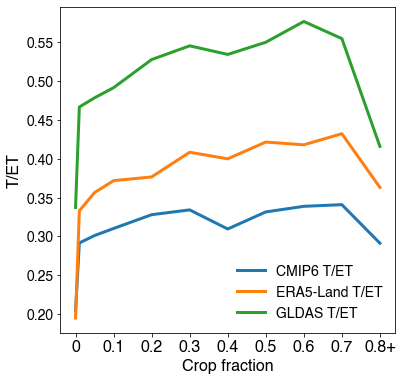

In [237]:

fig = plt.figure(figsize=(6,6))
plt.plot(bins,binned_cmip6_mean_t_et, lw=3, label = 'CMIP6 T/ET')
plt.plot(bins,binned_era5_t_et, lw=3, label = 'ERA5-Land T/ET')
plt.plot(bins,binned_gldas_t_et, lw=3, label='GLDAS T/ET')
plt.xlabel('Crop fraction', fontsize=16)
plt.xticks(np.arange(0, .81, .1))
plt.gca().set_xticklabels(['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8+'], fontsize=16)
plt.ylabel('T/ET', fontsize=16)
plt.legend(prop={'size': 14}, frameon=False)

plt.savefig('t-et-comparison.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

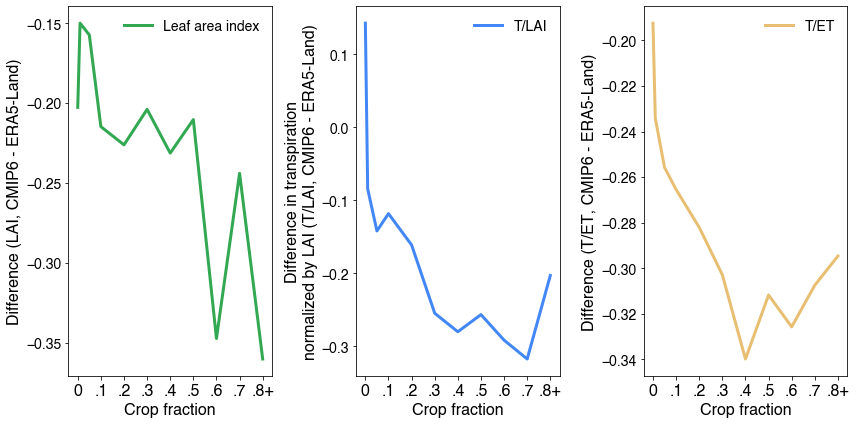

In [238]:
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].plot(bins, binned_lai_bias, label='Leaf area index', lw=3, c='#32a852')
# ax[0].plot(bins, binned_lai_bias_per_model.T, lw=1, c='#32a852')
ax[0].set_xlabel('Crop fraction', fontsize=16)
ax[0].set_xticks(np.arange(0, .81, .1))
ax[0].set_xticklabels(['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+'], fontsize=16)
ax[0].set_ylabel('Difference (LAI, CMIP6 - ERA5-Land)', fontsize=16)
ax[0].legend(prop={'size': 14}, frameon=False)


ax[1].plot(bins, np.array(binned_normalized_tran_cmip6)-np.array(binned_normalized_tran_era5), label='T/LAI', lw=3, c='#4287f5')
# ax[1].plot(bins, , label='T/LAI (CMIP6)', lw=3, c='r')
ax[1].set_xlabel('Crop fraction', fontsize=16)
ax[1].set_xticks(np.arange(0, .81, .1))
ax[1].set_xticklabels(['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+'], fontsize=16)
ax[1].set_ylabel('Difference in transpiration\nnormalized by LAI (T/LAI, CMIP6 - ERA5-Land)', fontsize=16)
ax[1].legend(prop={'size': 14}, frameon=False)

ax[2].plot(bins, binned_t_et_bias, label='T/ET', lw=3, c='#e8bf72')
ax[2].set_xlabel('Crop fraction', fontsize=16)
ax[2].set_xticks(np.arange(0, .81, .1))
ax[2].set_xticklabels(['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+'], fontsize=16)
ax[2].set_ylabel('Difference (T/ET, CMIP6 - ERA5-Land)', fontsize=16)
ax[2].legend(prop={'size': 14}, frameon=False)

plt.tight_layout()
plt.savefig('binned-lai-t-et-biases-cmip6-mean.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

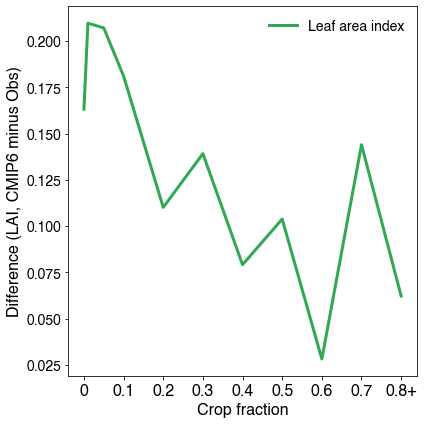

In [247]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(bins, binned_lai_obs_bias, label='Leaf area index', lw=3, c='#32a852')
# ax[0].plot(bins, binned_lai_bias_per_model.T, lw=1, c='#32a852')
ax.set_xlabel('Crop fraction', fontsize=16)
ax.set_xticks(np.arange(0, .81, .1))
ax.set_xticklabels(['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8+'], fontsize=16)
ax.set_ylabel('Difference (LAI, CMIP6 minus Obs)', fontsize=16)
ax.legend(prop={'size': 14}, frameon=False)

plt.tight_layout()
# plt.savefig('binned-lai-obs-biases-cmip6-mean.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

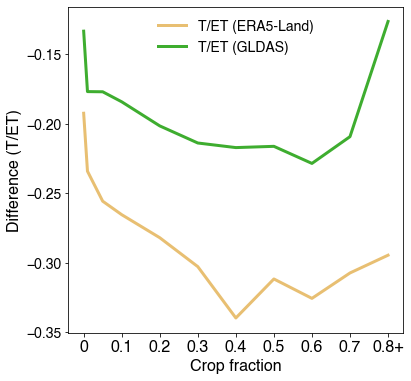

In [240]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(bins, binned_t_et_bias, label='T/ET (ERA5-Land)', lw=3, c='#e8bf72')
ax.plot(bins, binned_t_et_bias_gldas, label='T/ET (GLDAS)', lw=3, c='#3ead2f')
# ax[0].plot(bins, binned_lai_bias_per_model.T, lw=1, c='#32a852')
ax.set_xlabel('Crop fraction', fontsize=16)
ax.set_xticks(np.arange(0, .81, .1))
ax.set_xticklabels(['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8+'], fontsize=16)
ax.set_ylabel('Difference (T/ET)', fontsize=16)
ax.legend(prop={'size': 14}, frameon=False)

plt.savefig('binned-t-et-biases-cmip6-mean-gldas.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [241]:
model_frac_diff_bin1_era5 = []
model_frac_diff_bin1_cpc = []
for b in range(len(bins)):
    model_frac_diff_bin1_era5.append(len(np.where((med_diff_from_bin1_era5[b,:]>0) & (pval_diff_from_bin1_era5[b,:]<.05))[0])/len(cmip6_models)*100)
    model_frac_diff_bin1_cpc.append(len(np.where((med_diff_from_bin1_cpc[b,:]>0) & (pval_diff_from_bin1_cpc[b,:]<.05))[0])/len(cmip6_models)*100)


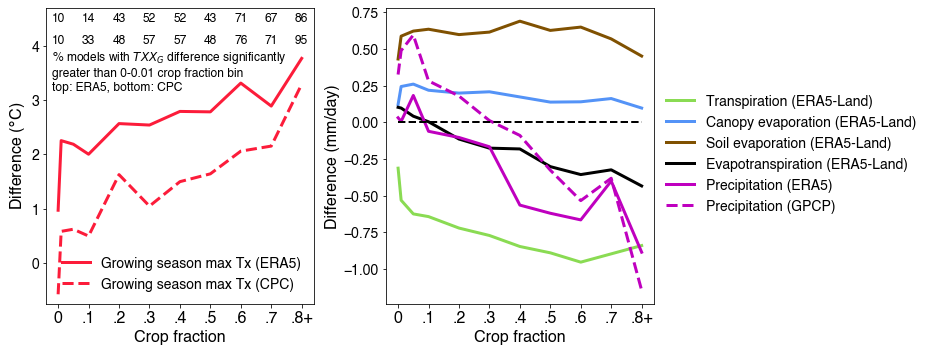

In [242]:
fig, ax = plt.subplots(1,2,figsize=(13,5))
ax[0].plot(bins,binned_tx_max_bias, label='Growing season max Tx (ERA5)', lw=3, c='#fc1c3a')
ax[0].plot(bins,binned_tx_max_bias_cpc, '--', label='Growing season max Tx (CPC)', lw=3, c='#fc1c3a')

ax[0].text(0, 4.5, '%.0f'%model_frac_diff_bin1_era5[0], fontdict={'family':'helvetica', 'size':12}, ha='center', va='center')
ax[0].text(0, 4.1, '%.0f'%model_frac_diff_bin1_cpc[0], fontdict={'family':'helvetica', 'size':12}, ha='center', va='center')
for b in range(3, len(bins)):
    ax[0].text(bins[b], 4.5, '%.0f'%model_frac_diff_bin1_era5[b], fontdict={'family':'helvetica', 'size':12}, ha='center', va='center')
    ax[0].text(bins[b], 4.1, '%.0f'%model_frac_diff_bin1_cpc[b], fontdict={'family':'helvetica', 'size':12}, ha='center', va='center')
ax[0].text(-.02, 3.52, '% models with $TXX_G$ difference significantly\ngreater than 0-0.01 crop fraction bin\ntop: ERA5, bottom: CPC', fontdict={'family':'helvetica', 'size':12}, ha='left', va='center')

# ax[0].plot([0, .8], [0, 0], '--k', lw=2)
ax[0].set_ylim([-.75,4.7])
ax[0].set_xlabel('Crop fraction', fontsize=16)
ax[0].set_xticks(np.arange(0, .81, .1))
ax[0].set_xticklabels(['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+'], fontsize=16)
ax[0].set_ylabel('Difference ($\degree$C)', fontsize=16)
ax[0].legend(prop={'size': 14}, frameon=False, loc='lower right')

ax[1].plot(bins,binned_tran_bias, label='Transpiration (ERA5-Land)', lw=3, c='#8adb53')
# ax[1].plot(bins,binned_tran_bias_gldas, '--', label='Transpiration (GLDAS)', lw=3, c='#8adb53')

ax[1].plot(bins,binned_evap_canopy_bias, label='Canopy evaporation (ERA5-Land)', lw=3, c='#5493f7')
# ax[1].plot(bins,binned_canopy_evap_bias_gldas, '--', label='Canopy evaporation (GLDAS)', lw=3, c='#5493f7')

ax[1].plot(bins,binned_evap_soil_bias, label='Soil evaporation (ERA5-Land)', lw=3, c='#805101')
# ax[1].plot(bins,binned_soil_evap_bias_gldas, '--', label='Soil evaporation (GLDAS)', lw=3, c='#805101')

ax[1].plot(bins,binned_et_bias, label='Evapotranspiration (ERA5-Land)', lw=3, c='k')
# ax[1].plot(bins,binned_et_bias_gldas, '--', label='Evapotranspiration (GLDAS)', lw=3, c='k')

ax[1].plot(bins,binned_pr_bias, label='Precipitation (ERA5)', lw=3, c='m')
ax[1].plot(bins,binned_pr_gpcp_bias, '--', label='Precipitation (GPCP)', lw=3, c='m')
ax[1].plot([0, .8], [0, 0], '--k', lw=2)
ax[1].legend(prop={'size': 14}, frameon=False, bbox_to_anchor=(1.0, .75))
ax[1].set_xticks(np.arange(0, .81, .1))
ax[1].set_xticklabels(['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+'], fontsize=16)
# ax[1].set_yticks(fontsize=16)
ax[1].set_xlabel('Crop fraction', fontsize=16)
ax[1].set_ylabel('Difference (mm/day)', fontsize=16)
plt.tight_layout()

plt.savefig('binned-biases-cmip6-mean.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

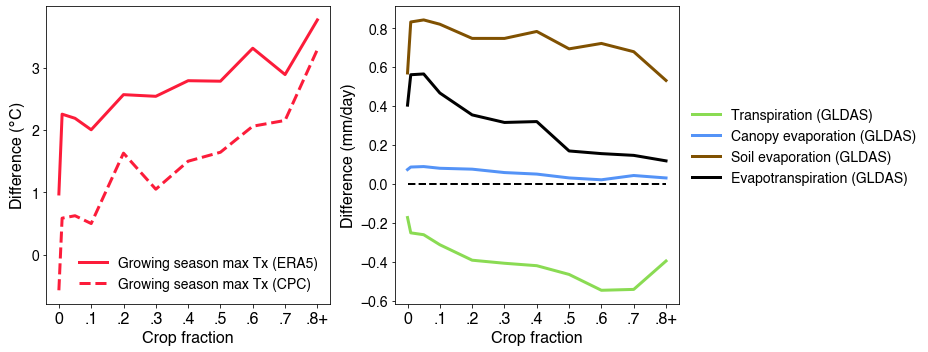

In [243]:
fig, ax = plt.subplots(1,2,figsize=(13,5))
ax[0].plot(bins,binned_tx_max_bias, label='Growing season max Tx (ERA5)', lw=3, c='#fc1c3a')
ax[0].plot(bins,binned_tx_max_bias_cpc, '--', label='Growing season max Tx (CPC)', lw=3, c='#fc1c3a')
# ax[0].plot([0, .8], [0, 0], '--k', lw=2)
ax[0].set_xlabel('Crop fraction', fontsize=16)
ax[0].set_xticks(np.arange(0, .81, .1))
ax[0].set_xticklabels(['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+'], fontsize=16)
ax[0].set_ylabel('Difference ($\degree$C)', fontsize=16)
ax[0].legend(prop={'size': 14}, frameon=False)

# ax[1].plot(bins,binned_tran_bias, label='Transpiration (ERA5-Land)', lw=3, c='#8adb53')
ax[1].plot(bins,binned_tran_bias_gldas, '-', label='Transpiration (GLDAS)', lw=3, c='#8adb53')

# ax[1].plot(bins,binned_evap_canopy_bias, label='Canopy evaporation (ERA5-Land)', lw=3, c='#5493f7')
ax[1].plot(bins,binned_canopy_evap_bias_gldas, '-', label='Canopy evaporation (GLDAS)', lw=3, c='#5493f7')

# ax[1].plot(bins,binned_evap_soil_bias, label='Soil evaporation (ERA5-Land)', lw=3, c='#805101')
ax[1].plot(bins,binned_soil_evap_bias_gldas, '-', label='Soil evaporation (GLDAS)', lw=3, c='#805101')

# ax[1].plot(bins,binned_et_bias, label='Evapotranspiration (ERA5-Land)', lw=3, c='k')
ax[1].plot(bins,binned_et_bias_gldas, '-', label='Evapotranspiration (GLDAS)', lw=3, c='k')

# ax[1].plot(bins,binned_pr_bias, label='Precipitation (ERA5)', lw=3, c='m')
# ax[1].plot(bins,binned_pr_gpcp_bias, '-', label='Precipitation (GPCP)', lw=3, c='m')
ax[1].plot([0, .8], [0, 0], '--k', lw=2)
ax[1].legend(prop={'size': 14}, frameon=False, bbox_to_anchor=(1.0, .7))
ax[1].set_xticks(np.arange(0, .81, .1))
ax[1].set_xticklabels(['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+'], fontsize=16)
# ax[1].set_yticks(fontsize=16)
ax[1].set_xlabel('Crop fraction', fontsize=16)
ax[1].set_ylabel('Difference (mm/day)', fontsize=16)
plt.tight_layout()

# plt.savefig('binned-biases-cmip6-mean-gldas.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

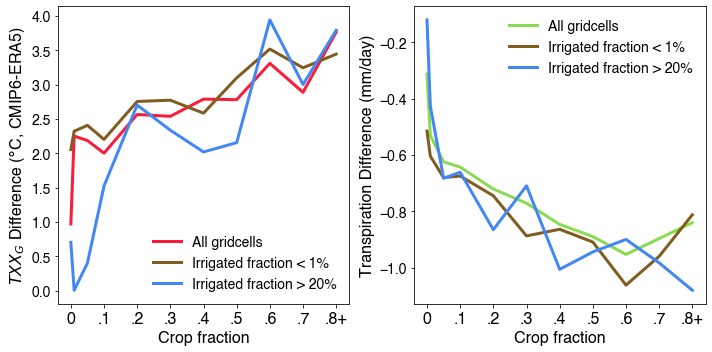

In [246]:

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(bins,binned_tx_max_bias, label='All gridcells', lw=3, c='#fc1c3a')
ax[0].plot(bins,binned_tx_max_bias_no_irr, label='Irrigated fraction < 1%', lw=3, c='#805c1f')
ax[0].plot(bins,binned_tx_max_bias_high_irr, label='Irrigated fraction > 20%', lw=3, c='#4287f5')
# ax[0].plot(bins,binned_tx_max_bias_cpc, '--', label='Growing season max Tx (CPC)', lw=3, c='#fc1c3a')
ax[0].set_xlabel('Crop fraction', fontsize=16)
ax[0].set_xticks(np.arange(0, .81, .1))
ax[0].set_xticklabels(['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+'], fontsize=16)
ax[0].set_ylabel('$TXX_G$ Difference ($\degree$C, CMIP6-ERA5)', fontsize=16)
ax[0].legend(prop={'size': 14}, frameon=False)


# ax[1].plot(bins,binned_tran_bias, label='Transpiration (ERA5-Land)', lw=3, c='#8adb53')
ax[1].plot(bins,binned_tran_bias, '-', label='All gridcells', lw=3, c='#8adb53')
ax[1].plot(bins,binned_tran_bias_no_irr, label='Irrigated fraction < 1%', lw=3, c='#805c1f')
ax[1].plot(bins,binned_tran_bias_high_irr, label='Irrigated fraction > 20%', lw=3, c='#4287f5')

# ax[1].plot([0, .8], [0, 0], '--k', lw=2)
ax[1].legend(prop={'size': 14}, frameon=False)
ax[1].set_xticks(np.arange(0, .81, .1))
ax[1].set_xticklabels(['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+'], fontsize=16)
# ax[1].set_yticks(fontsize=16)
ax[1].set_xlabel('Crop fraction', fontsize=16)
ax[1].set_ylabel('Transpiration Difference (mm/day)', fontsize=16)
plt.tight_layout()

plt.savefig('binned-biases-cmip6-era5-irr.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

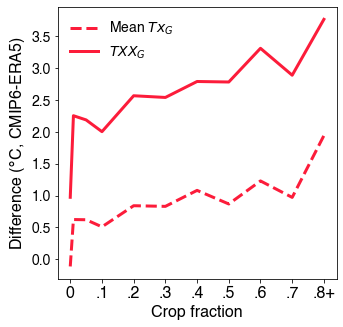

In [66]:

fig, ax = plt.subplots(1,1,figsize=(5,5))
plt.plot(bins,binned_tx_mean_bias, '--', label='Mean $Tx_G$', lw=3, c='#fc1c3a')
plt.plot(bins,binned_tx_max_bias, label='$TXX_G$', lw=3, c='#fc1c3a')
plt.xlabel('Crop fraction', fontsize=16)
plt.xticks(np.arange(0, .81, .1))
plt.gca().set_xticklabels(['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8+'], fontsize=16)
plt.ylabel('Difference ($\degree$C, CMIP6-ERA5)', fontsize=16)
plt.legend(prop={'size': 14}, frameon=False)


# plt.savefig('binned-biases-cmip6-era5-mean-vs-max-tx.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

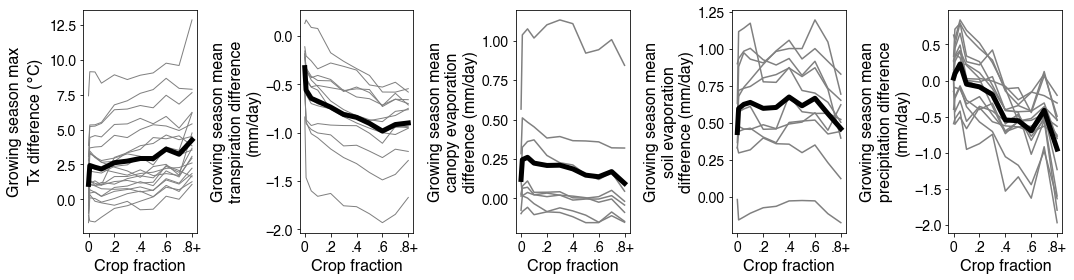

In [67]:

fig, ax = plt.subplots(1,5,figsize=(15,4))

ax[0].plot(bins, np.array(binned_tx_max_bias_per_model).T, color='gray', lw=1)
ax[0].plot(bins, np.nanmean(np.array(binned_tx_max_bias_per_model), axis=0), color='k', lw=5)
ax[0].set_xlabel('Crop fraction')
ax[0].set_ylabel('Growing season max\nTx difference ($\degree$C)')
ax[0].set_xticks(np.arange(0, .81, .2))
ax[0].set_xticklabels(['0', '.2', '.4', '.6', '.8+'])

ax[1].plot(bins, np.array(binned_tran_bias_per_model).T, color='gray', lw=1)
ax[1].plot(bins, np.nanmean(np.array(binned_tran_bias_per_model), axis=0), color='k', lw=5)
ax[1].set_xlabel('Crop fraction')
ax[1].set_ylabel('Growing season mean\ntranspiration difference\n(mm/day)')
ax[1].set_xticks(np.arange(0, .81, .2))
ax[1].set_xticklabels(['0', '.2', '.4', '.6', '.8+'])

ax[2].plot(bins, np.array(binned_evap_canopy_bias_per_model).T, color='gray')
ax[2].plot(bins, np.nanmean(np.array(binned_evap_canopy_bias_per_model), axis=0), color='k', lw=5)
ax[2].set_xlabel('Crop fraction')
ax[2].set_ylabel('Growing season mean\ncanopy evaporation\ndifference (mm/day)')
ax[2].set_xticks(np.arange(0, .81, .2))
ax[2].set_xticklabels(['0', '.2', '.4', '.6', '.8+'])

ax[3].plot(bins, np.array(binned_evap_soil_bias_per_model).T, color='gray')
ax[3].plot(bins, np.nanmean(np.array(binned_evap_soil_bias_per_model), axis=0), color='k', lw=5)
ax[3].set_xlabel('Crop fraction')
ax[3].set_ylabel('Growing season mean\nsoil evaporation\ndifference (mm/day)')
ax[3].set_xticks(np.arange(0, .81, .2))
ax[3].set_xticklabels(['0', '.2', '.4', '.6', '.8+'])

ax[4].plot(bins, np.array(binned_pr_bias_per_model).T, color='gray')
ax[4].plot(bins, np.nanmean(np.array(binned_pr_bias_per_model), axis=0), color='k', lw=5)
ax[4].set_xlabel('Crop fraction')
ax[4].set_ylabel('Growing season mean\nprecipitation difference\n(mm/day)')
ax[4].set_xticks(np.arange(0, .81, .2))
ax[4].set_xticklabels(['0', '.2', '.4', '.6', '.8+'])
plt.tight_layout()

# plt.savefig('binned-biases-cmip6-members.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [68]:
cmip6_ha_bias_global_grop_1d = cmip6_ha_bias.reshape([cmip6_ha_bias.shape[0], cmip6_ha_bias.shape[1]*cmip6_ha_bias.shape[2]])

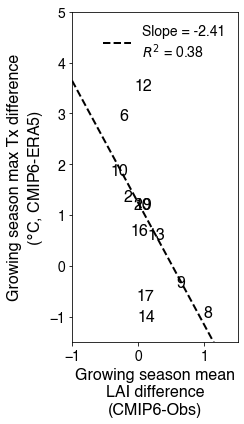

In [70]:
use_obs_lai = True

nn_cropland = np.where((crop_all_area_regrid_1d >= 0))[0]

tasmax_grow_max_bias_time_mean_2d_crop = tasmax_grow_max_bias_time_mean_2d[:, nn_cropland]
tasmax_grow_max_bias_time_mean_2d_crop_no_miroc6 = tasmax_grow_max_bias_time_mean_2d_crop.copy()
tasmax_grow_max_bias_time_mean_2d_crop_no_miroc6[14] = np.nan

if use_obs_lai:
    lai_grow_bias_time_mean_2d_crop = lai_grow_obs_bias_time_mean_2d[:, nn_cropland]
    lai_grow_bias_time_mean_2d_crop_no_miroc6 = lai_grow_bias_time_mean_2d_crop.copy()
    lai_grow_bias_time_mean_2d_crop_no_miroc6[14] = np.nan
else:
    lai_grow_bias_time_mean_2d_crop = lai_grow_bias_time_mean_2d[:, nn_cropland]
    lai_grow_bias_time_mean_2d_crop_no_miroc6 = lai_grow_bias_time_mean_2d_crop.copy()
    lai_grow_bias_time_mean_2d_crop_no_miroc6[14] = np.nan

# tran_grow_bias_time_mean_2d_crop = tran_bias_time_mean_2d[:, nn_cropland]
# tran_grow_bias_time_mean_2d_crop_no_miroc6 = tran_grow_bias_time_mean_2d_crop.copy()
# tran_grow_bias_time_mean_2d_crop_no_miroc6[14] = np.nan

tasmax_grow_max_bias_time_mean_2d_crop = np.nanmean(tasmax_grow_max_bias_time_mean_2d_crop, axis=1)
tasmax_grow_max_bias_time_mean_2d_crop_no_miroc6 = np.nanmean(tasmax_grow_max_bias_time_mean_2d_crop_no_miroc6, axis=1)

lai_grow_bias_time_mean_2d_crop = np.nanmean(lai_grow_bias_time_mean_2d_crop, axis=1)
lai_grow_bias_time_mean_2d_crop_no_miroc6 = np.nanmean(lai_grow_bias_time_mean_2d_crop_no_miroc6, axis=1)

# tran_grow_bias_time_mean_2d_crop = np.nanmean(tran_grow_bias_time_mean_2d_crop, axis=1)
# tran_grow_bias_time_mean_2d_crop_no_miroc6 = np.nanmean(tran_grow_bias_time_mean_2d_crop_no_miroc6, axis=1)


nn = np.where(~np.isnan(tasmax_grow_max_bias_time_mean_2d_crop_no_miroc6) & ~np.isnan(lai_grow_bias_time_mean_2d_crop_no_miroc6))[0]
X = sm.add_constant(lai_grow_bias_time_mean_2d_crop_no_miroc6[nn])
mdl_lai_temp = sm.OLS(tasmax_grow_max_bias_time_mean_2d_crop_no_miroc6[nn], X).fit()


# nn = np.where(~np.isnan(tran_grow_bias_time_mean_2d_crop_no_miroc6) & ~np.isnan(lai_grow_bias_time_mean_2d_crop_no_miroc6))[0]
# X = sm.add_constant(lai_grow_bias_time_mean_2d_crop_no_miroc6[nn])
# mdl_lai_trans = sm.OLS(tran_grow_bias_time_mean_2d_crop_no_miroc6[nn], X).fit()

mdl_leg = {}

fig, ax = plt.subplots(figsize=(3.5,6))

if use_obs_lai:
    x1 = -1
    x2 = 1.5
else:
    x1 = -1
    x2 = 1
ax.set_ylim([-1.5, 5])
ax.set_xlim([x1, x2])
ax.plot([x1, x2], [mdl_lai_temp.params[0]+x1*mdl_lai_temp.params[1], \
                    mdl_lai_temp.params[0]+x2*mdl_lai_temp.params[1]], '--k', lw=2, label='Slope = %.2f\n$R^2$ = %.2f'%(mdl_lai_temp.params[1], mdl_lai_temp.rsquared))
for m in range(lai_grow_bias_time_mean_2d_crop.size):
    if not np.isnan(lai_grow_bias_time_mean_2d_crop[m]) and not np.isnan(tasmax_grow_max_bias_time_mean_2d_crop[m]):
        mdl_leg[m] = cmip6_models[m]
        
        # miroc 6
        if m == 14:
            ax.text(lai_grow_bias_time_mean_2d_crop[m], tasmax_grow_max_bias_time_mean_2d_crop[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='r')
        else:
            ax.text(lai_grow_bias_time_mean_2d_crop[m], tasmax_grow_max_bias_time_mean_2d_crop[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='k')
# ax[0].scatter(yearly_tran_grow_bias_mean_global_crop_1d, tasmax_max_bias_global_crop_1d, s=60, c='k')
# ax[0].set_xticks([-.5, -1, -1.5, -2])
if use_obs_lai:
    ax.set_xlabel('Growing season mean\nLAI difference\n(CMIP6-Obs)')
else:
    ax.set_xlabel('Growing season mean\nLAI difference\n(CMIP6-ERA5-Land)')
ax.set_ylabel('Growing season max Tx difference\n($\degree$C, CMIP6-ERA5)')
ax.legend(frameon=False, prop={'size': 14})

plt.tight_layout()

if use_obs_lai:
    plt.savefig('lai-tx-obs-bias-model-comparison.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)
else:
    plt.savefig('lai-tx-bias-model-comparison.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)



# x1 = -1
# x2 = 1
# ax[1].set_ylim([-1, .5])
# ax[1].set_xlim([x1, x2])
# ax[1].plot([x1, x2], [mdl_lai_trans.params[0]+x1*mdl_lai_trans.params[1], \
#                     mdl_lai_trans.params[0]+x2*mdl_lai_trans.params[1]], '--k', lw=2, label='Slope = %.2f\n$R^2$ = %.2f'%(mdl_lai_trans.params[1], mdl_lai_trans.rsquared))
# for m in range(lai_grow_bias_time_mean_2d_crop.size):
#     if not np.isnan(lai_grow_bias_time_mean_2d_crop[m]) and not np.isnan(tran_grow_bias_time_mean_2d_crop[m]):
#         mdl_leg[m] = cmip6_models[m]
        
#         # miroc 6
#         if m == 14:
#             ax[1].text(lai_grow_bias_time_mean_2d_crop[m], tran_grow_bias_time_mean_2d_crop[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='r')
#         else:
#             ax[1].text(lai_grow_bias_time_mean_2d_crop[m], tran_grow_bias_time_mean_2d_crop[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='k')

# ax[1].set_xlabel('Growing season mean\nLAI difference\n(CMIP6-ERA5-Land)')
# ax[1].set_ylabel('Growing season transpiration difference\n(mm/day, ERA5-Land)')
# ax[1].legend(frameon=False, prop={'size': 14})



plt.savefig('lai-tx-bias-model-comparison.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

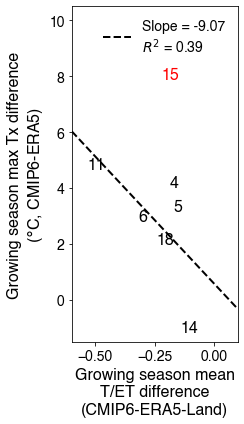

In [71]:
nn_cropland = np.where((crop_all_area_regrid_1d >= 0))[0]

tasmax_grow_max_bias_time_mean_2d_crop = tasmax_grow_max_bias_time_mean_2d[:, nn_cropland]
tasmax_grow_max_bias_time_mean_2d_crop_no_miroc6 = tasmax_grow_max_bias_time_mean_2d_crop.copy()
tasmax_grow_max_bias_time_mean_2d_crop_no_miroc6[14] = np.nan


cmip6_t_et_grow_bias_time_mean_2d_crop = cmip6_t_et_grow_bias_time_mean_2d[:, nn_cropland]
cmip6_t_et_grow_bias_time_mean_2d_crop_no_miroc6 = cmip6_t_et_grow_bias_time_mean_2d_crop.copy()
cmip6_t_et_grow_bias_time_mean_2d_crop_no_miroc6[14] = np.nan

tasmax_grow_max_bias_time_mean_2d_crop = np.nanmean(tasmax_grow_max_bias_time_mean_2d_crop, axis=1)
tasmax_grow_max_bias_time_mean_2d_crop_no_miroc6 = np.nanmean(tasmax_grow_max_bias_time_mean_2d_crop_no_miroc6, axis=1)

cmip6_t_et_grow_bias_time_mean_2d_crop = np.nanmean(cmip6_t_et_grow_bias_time_mean_2d_crop, axis=1)
cmip6_t_et_grow_bias_time_mean_2d_crop_no_miroc6 = np.nanmean(cmip6_t_et_grow_bias_time_mean_2d_crop_no_miroc6, axis=1)



nn = np.where(~np.isnan(tasmax_grow_max_bias_time_mean_2d_crop_no_miroc6) & ~np.isnan(cmip6_t_et_grow_bias_time_mean_2d_crop_no_miroc6))[0]
X = sm.add_constant(cmip6_t_et_grow_bias_time_mean_2d_crop_no_miroc6[nn])
mdl_t_et_temp = sm.OLS(tasmax_grow_max_bias_time_mean_2d_crop_no_miroc6[nn], X).fit()



fig = plt.figure(figsize=(3.5,6))

x1 = -.6
x2 = .1
plt.ylim([-1.5, 10.5])
plt.xlim([x1, x2])
plt.plot([x1, x2], [mdl_t_et_temp.params[0]+x1*mdl_t_et_temp.params[1], \
                    mdl_t_et_temp.params[0]+x2*mdl_t_et_temp.params[1]], '--k', lw=2, label='Slope = %.2f\n$R^2$ = %.2f'%(mdl_t_et_temp.params[1], mdl_t_et_temp.rsquared))
for m in range(cmip6_t_et_grow_bias_time_mean_2d_crop.size):
    if not np.isnan(cmip6_t_et_grow_bias_time_mean_2d_crop[m]) and not np.isnan(tasmax_grow_max_bias_time_mean_2d_crop[m]):
        mdl_leg[m] = cmip6_models[m]
        
        # miroc 6
        if m == 14:
            plt.text(cmip6_t_et_grow_bias_time_mean_2d_crop[m], tasmax_grow_max_bias_time_mean_2d_crop[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='r')
        else:
            plt.text(cmip6_t_et_grow_bias_time_mean_2d_crop[m], tasmax_grow_max_bias_time_mean_2d_crop[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='k')

plt.xlabel('Growing season mean\nT/ET difference\n(CMIP6-ERA5-Land)')
plt.ylabel('Growing season max Tx difference\n($\degree$C, CMIP6-ERA5)')
plt.legend(frameon=False, prop={'size': 14})

plt.tight_layout()

plt.savefig('t-et-tx-bias-model-comparison.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

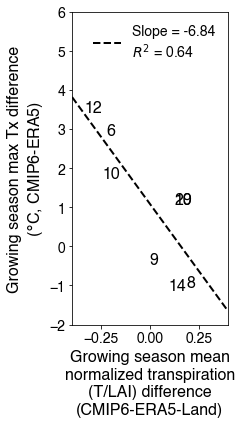

In [73]:
nn_cropland = np.where((crop_all_area_regrid_1d >= 0))[0]

tasmax_grow_max_bias_time_mean_2d_crop = tasmax_grow_max_bias_time_mean_2d[:, nn_cropland]
tasmax_grow_max_bias_time_mean_2d_crop_no_miroc6 = tasmax_grow_max_bias_time_mean_2d_crop.copy()
tasmax_grow_max_bias_time_mean_2d_crop_no_miroc6[14] = np.nan

cmip6_normalized_tran_mean_2d_crop = np.full([cmip6_normalized_tran_mean_2d.shape[0], nn_cropland.size], np.nan)
for m in range(len(cmip6_models)):
    cmip6_normalized_tran_mean_2d_crop[m, :] = cmip6_normalized_tran_mean_2d[m, nn_cropland] - era5_normalized_tran_1d[nn_cropland].reshape([nn_cropland.size])
cmip6_normalized_tran_mean_2d_crop_no_miroc6 = cmip6_normalized_tran_mean_2d_crop.copy()
cmip6_normalized_tran_mean_2d_crop_no_miroc6[14] = np.nan

tasmax_grow_max_bias_time_mean_2d_crop = np.nanmean(tasmax_grow_max_bias_time_mean_2d_crop, axis=1)
tasmax_grow_max_bias_time_mean_2d_crop_no_miroc6 = np.nanmean(tasmax_grow_max_bias_time_mean_2d_crop_no_miroc6, axis=1)

cmip6_normalized_tran_mean_2d_crop = np.nanmean(cmip6_normalized_tran_mean_2d_crop, axis=1)
cmip6_normalized_tran_mean_2d_crop_no_miroc6 = np.nanmean(cmip6_normalized_tran_mean_2d_crop_no_miroc6, axis=1)



nn = np.where(~np.isnan(tasmax_grow_max_bias_time_mean_2d_crop_no_miroc6) & ~np.isnan(cmip6_normalized_tran_mean_2d_crop_no_miroc6))[0]
X = sm.add_constant(cmip6_normalized_tran_mean_2d_crop_no_miroc6[nn])
mdl_norm_t_temp = sm.OLS(tasmax_grow_max_bias_time_mean_2d_crop_no_miroc6[nn], X).fit()



fig = plt.figure(figsize=(3.5,6))

x1 = -.4
x2 = .4
plt.ylim([-2, 6])
plt.xlim([x1, x2])
plt.plot([x1, x2], [mdl_norm_t_temp.params[0]+x1*mdl_norm_t_temp.params[1], \
                    mdl_norm_t_temp.params[0]+x2*mdl_norm_t_temp.params[1]], '--k', lw=2, label='Slope = %.2f\n$R^2$ = %.2f'%(mdl_norm_t_temp.params[1], mdl_norm_t_temp.rsquared))
for m in range(cmip6_t_et_grow_bias_time_mean_2d_crop.size):
    if not np.isnan(cmip6_normalized_tran_mean_2d_crop[m]) and not np.isnan(tasmax_grow_max_bias_time_mean_2d_crop[m]):
        mdl_leg[m] = cmip6_models[m]
        
        # miroc 6
        if m == 14:
            plt.text(cmip6_normalized_tran_mean_2d_crop[m], tasmax_grow_max_bias_time_mean_2d_crop[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='r')
        else:
            plt.text(cmip6_normalized_tran_mean_2d_crop[m], tasmax_grow_max_bias_time_mean_2d_crop[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='k')

plt.xlabel('Growing season mean\nnormalized transpiration\n(T/LAI) difference\n(CMIP6-ERA5-Land)')
plt.ylabel('Growing season max Tx difference\n($\degree$C, CMIP6-ERA5)')
plt.legend(frameon=False, prop={'size': 14})

plt.tight_layout()

plt.savefig('norm-t-tx-bias-model-comparison.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

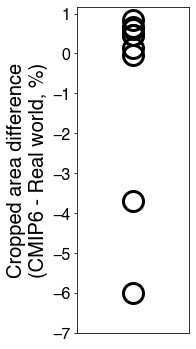

In [74]:


plt.figure(figsize=(2,6))
plt.plot([0]*cmip6_ha_bias_mean_2d.shape[0], np.nanmean(cmip6_ha_bias_mean_2d[:,nn_cropland], axis=1), 'ko', markersize=20, markerfacecolor="None", mew=3)

plt.yticks(np.arange(-7,1.1), fontsize=16)
plt.ylabel('Cropped area difference\n(CMIP6 - Real world, %)', fontsize=20)
plt.gca().xaxis.set_visible(False)

plt.savefig('cmip6-ha-bias.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

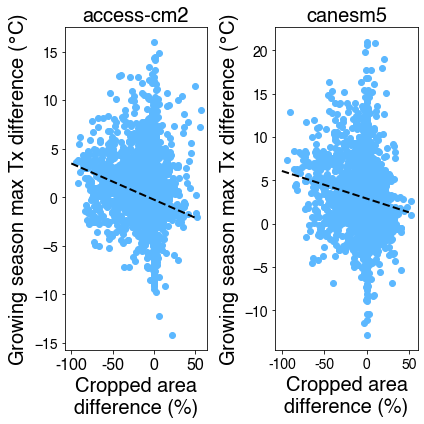

In [75]:
m = 0
x = cmip6_ha_bias_mean_2d[m,nn_cropland]
y = tasmax_grow_max_bias_time_mean_2d[m,nn_cropland]

nn = np.where((~np.isnan(x)) & (~np.isnan(y)))[0]


X = sm.add_constant(x[nn])
mdl0 = sm.OLS(y[nn], X).fit()

x1 = -100
x2 = 50
fig, ax = plt.subplots(1, 2, figsize=(6,6))
ax[0].scatter(x,y, c='#5cb8ff')
ax[0].plot([x1,x2], [mdl0.params[0]+x1*mdl0.params[1], mdl0.params[0]+x2*mdl0.params[1]], '--k', lw=2)
ax[0].set_xticks([-100, -50, 0, 50])
ax[0].set_xticklabels([-100, -50, 0, 50], fontsize=16)
# ax[0].set_yticks(fontsize=16)
ax[0].set_ylabel('Growing season max Tx difference ($\degree$C)', fontsize=20)
ax[0].set_xlabel('Cropped area\ndifference (%)', fontsize=20)
ax[0].set_title(cmip6_models[m], fontsize=20)



m = 5
x = cmip6_ha_bias_mean_2d[m,nn_cropland]
y = tasmax_grow_max_bias_time_mean_2d[m,nn_cropland]

nn = np.where((~np.isnan(x)) & (~np.isnan(y)))[0]


X = sm.add_constant(x[nn])
mdl1 = sm.OLS(y[nn], X).fit()


ax[1].scatter(x,y, c='#5cb8ff')
ax[1].plot([x1,x2], [mdl1.params[0]+x1*mdl1.params[1], mdl1.params[0]+x2*mdl1.params[1]], '--k', lw=2, )
ax[1].set_xticks([-100, -50, 0, 50])
ax[1].set_xticklabels([-100, -50, 0, 50])
# ax[1].set_yticks(fontsize=16)
ax[1].set_ylabel('Growing season max Tx difference ($\degree$C)', fontsize=20)
ax[1].set_xlabel('Cropped area\ndifference (%)', fontsize=20)
ax[1].set_title(cmip6_models[m], fontsize=20)

plt.tight_layout()

plt.savefig('cmip6-ha-bias-spatial-scatters.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

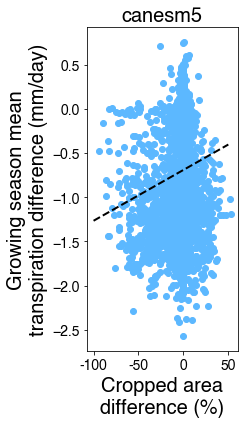

In [76]:
m = 5
x = cmip6_ha_bias_mean_2d[m,nn_cropland]
y = tran_bias_time_mean_2d[m,nn_cropland]

nn = np.where((~np.isnan(x)) & (~np.isnan(y)))[0]


X = sm.add_constant(x[nn])
mdl0 = sm.OLS(y[nn], X).fit()

x1 = -100
x2 = 50
fig, ax = plt.subplots(1, 1, figsize=(3.5,6))
ax.scatter(x,y, c='#5cb8ff')
ax.plot([x1,x2], [mdl0.params[0]+x1*mdl0.params[1], mdl0.params[0]+x2*mdl0.params[1]], '--k', lw=2)
ax.set_xticks([-100, -50, 0, 50])
ax.set_xticklabels([-100, -50, 0, 50])
# ax[0].set_yticks(fontsize=16)
ax.set_ylabel('Growing season mean\ntranspiration difference (mm/day)', fontsize=20)
ax.set_xlabel('Cropped area\ndifference (%)', fontsize=20)
ax.set_title(cmip6_models[m], fontsize=20)



# m = 3
# x = cmip6_ha_bias_mean_2d[m,nn_cropland]
# y = tran_bias_time_mean_2d[m,nn_cropland]

# nn = np.where((~np.isnan(x)) & (~np.isnan(y)))[0]


# X = sm.add_constant(x[nn])
# mdl1 = sm.OLS(y[nn], X).fit()


# ax[1].scatter(x,y, c='#5cb8ff')
# ax[1].plot([x1,x2], [mdl1.params[0]+x1*mdl1.params[1], mdl1.params[0]+x2*mdl1.params[1]], '--k', lw=2, )
# ax[1].set_xticks([-100, -50, 0, 50])
# ax[1].set_xticklabels([-100, -50, 0, 50], fontsize=16)
# # ax[1].set_yticks(fontsize=16)
# ax[1].set_ylabel('Growing season max Tx bias ($\degree$C)', fontsize=20)
# ax[1].set_xlabel('Cropped area bias\n(%)', fontsize=20)
# ax[1].set_title(cmip6_models[m], fontsize=20)

plt.tight_layout()

plt.savefig('canesm5-ha-bias-trans-spatial-scatters.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

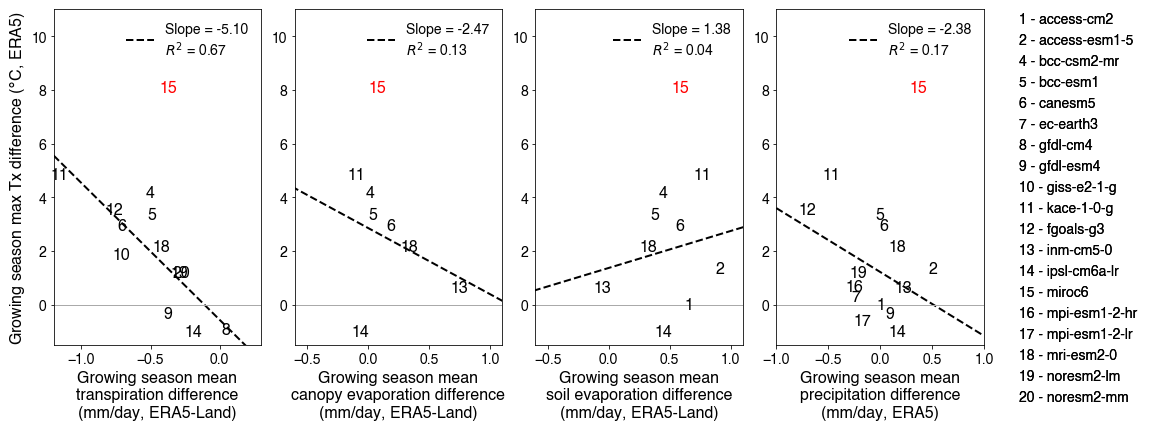

In [78]:
import collections

nn_cropland = np.where((crop_all_area_regrid_1d >= 0))[0]

tasmax_max_bias_global_crop_1d = yearly_tasmax_grow_max_bias.reshape([yearly_tasmax_grow_max_bias.shape[0], yearly_tasmax_grow_max_bias.shape[1], \
                                                                  yearly_tasmax_grow_max_bias.shape[2]*yearly_tasmax_grow_max_bias.shape[3]])
tasmax_max_bias_global_crop_1d = np.nanmean(np.nanmean(tasmax_max_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
tasmax_max_bias_global_crop_1d_no_miroc6 = tasmax_max_bias_global_crop_1d.copy()
tasmax_max_bias_global_crop_1d_no_miroc6[14] = np.nan


yearly_tran_grow_bias_mean_global_crop_1d = yearly_tran_grow_bias.reshape([yearly_tran_grow_bias.shape[0], yearly_tran_grow_bias.shape[1], \
                                                                  yearly_tran_grow_bias.shape[2]*yearly_tran_grow_bias.shape[3]])
yearly_tran_grow_bias_mean_global_crop_1d = np.nanmean(np.nanmean(yearly_tran_grow_bias_mean_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
yearly_tran_grow_bias_mean_global_crop_1d_no_miroc6 = yearly_tran_grow_bias_mean_global_crop_1d.copy()
yearly_tran_grow_bias_mean_global_crop_1d_no_miroc6[14] = np.nan

nn = np.where(~np.isnan(tasmax_max_bias_global_crop_1d_no_miroc6) & ~np.isnan(yearly_tran_grow_bias_mean_global_crop_1d_no_miroc6))[0]
X = sm.add_constant(yearly_tran_grow_bias_mean_global_crop_1d_no_miroc6[nn])
mdl_tran = sm.OLS(tasmax_max_bias_global_crop_1d_no_miroc6[nn], X).fit()



yearly_evap_from_canopy_grow_bias_mean_global_crop_1d = yearly_evap_from_canopy_grow_bias.reshape([yearly_evap_from_canopy_grow_bias.shape[0], yearly_evap_from_canopy_grow_bias.shape[1], \
                                                                  yearly_evap_from_canopy_grow_bias.shape[2]*yearly_evap_from_canopy_grow_bias.shape[3]])
yearly_evap_from_canopy_grow_bias_mean_global_crop_1d = np.nanmean(np.nanmean(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
yearly_evap_from_canopy_grow_bias_mean_global_crop_1d_no_miroc6 = yearly_evap_from_canopy_grow_bias_mean_global_crop_1d.copy()
yearly_evap_from_canopy_grow_bias_mean_global_crop_1d_no_miroc6[14] = np.nan

nn = np.where(~np.isnan(tasmax_max_bias_global_crop_1d_no_miroc6) & ~np.isnan(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d_no_miroc6))[0]
X = sm.add_constant(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d_no_miroc6[nn])
mdl_canopy = sm.OLS(tasmax_max_bias_global_crop_1d_no_miroc6[nn], X).fit()



yearly_evap_from_soil_grow_bias_mean_global_crop_1d = yearly_evap_from_soil_grow_bias.reshape([yearly_evap_from_soil_grow_bias.shape[0], yearly_evap_from_soil_grow_bias.shape[1], \
                                                                  yearly_evap_from_soil_grow_bias.shape[2]*yearly_evap_from_soil_grow_bias.shape[3]])
yearly_evap_from_soil_grow_bias_mean_global_crop_1d = np.nanmean(np.nanmean(yearly_evap_from_soil_grow_bias_mean_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
yearly_evap_from_soil_grow_bias_mean_global_crop_1d_no_miroc6 = yearly_evap_from_soil_grow_bias_mean_global_crop_1d.copy()
yearly_evap_from_soil_grow_bias_mean_global_crop_1d_no_miroc6[14] = np.nan


nn = np.where(~np.isnan(tasmax_max_bias_global_crop_1d_no_miroc6) & ~np.isnan(yearly_evap_from_soil_grow_bias_mean_global_crop_1d_no_miroc6))[0]
X = sm.add_constant(yearly_evap_from_soil_grow_bias_mean_global_crop_1d_no_miroc6[nn])
mdl_soil = sm.OLS(tasmax_max_bias_global_crop_1d_no_miroc6[nn], X).fit()



yearly_pr_grow_bias_mean_global_crop_1d = yearly_pr_grow_bias.reshape([yearly_pr_grow_bias.shape[0], yearly_pr_grow_bias.shape[1], \
                                                                  yearly_pr_grow_bias.shape[2]*yearly_pr_grow_bias.shape[3]])
yearly_pr_grow_bias_mean_global_crop_1d = np.nanmean(np.nanmean(yearly_pr_grow_bias_mean_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
yearly_pr_grow_bias_mean_global_crop_1d_no_miroc6 = yearly_pr_grow_bias_mean_global_crop_1d.copy()
yearly_pr_grow_bias_mean_global_crop_1d_no_miroc6[14] = np.nan

nn = np.where(~np.isnan(tasmax_max_bias_global_crop_1d_no_miroc6) & ~np.isnan(yearly_pr_grow_bias_mean_global_crop_1d_no_miroc6))[0]
X = sm.add_constant(yearly_pr_grow_bias_mean_global_crop_1d_no_miroc6[nn])
mdl_pr = sm.OLS(tasmax_max_bias_global_crop_1d_no_miroc6[nn], X).fit()

mdl_leg = {}

x1 = -1.2
x2 = 0.3
fig, ax = plt.subplots(1,4,figsize=(14,6))

# plt.plot([np.nanmean(yearly_tran_grow_bias_mean_global_crop_1d), np.nanmean(yearly_tran_grow_bias_mean_global_crop_1d)], [0,8], '-k')
# plt.plot([x1, x2], [np.nanmean(tasmax_max_bias_global_crop_1d), np.nanmean(tasmax_max_bias_global_crop_1d)], '-k')
ax[0].set_ylim([-1.5, 11])
ax[0].set_xlim([-1.2, .3])
ax[0].plot([x1, x2], [mdl_tran.params[0]+x1*mdl_tran.params[1], \
                    mdl_tran.params[0]+x2*mdl_tran.params[1]], '--k', lw=2, label='Slope = %.2f\n$R^2$ = %.2f'%(mdl_tran.params[1], mdl_tran.rsquared))
ax[0].plot([x1,x2], [0,0], '-', lw=1, c='#aaaaaa')
for m in range(yearly_tran_grow_bias_mean_global_crop_1d.size):
    if not np.isnan(yearly_tran_grow_bias_mean_global_crop_1d[m]) and not np.isnan(tasmax_max_bias_global_crop_1d[m]):
        mdl_leg[m] = cmip6_models[m]
        
        # miroc 6
        if m == 14:
            ax[0].text(yearly_tran_grow_bias_mean_global_crop_1d[m], tasmax_max_bias_global_crop_1d[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='r')
        else:
            ax[0].text(yearly_tran_grow_bias_mean_global_crop_1d[m], tasmax_max_bias_global_crop_1d[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='k')
# ax[0].scatter(yearly_tran_grow_bias_mean_global_crop_1d, tasmax_max_bias_global_crop_1d, s=60, c='k')
ax[0].set_xlabel('Growing season mean\ntranspiration difference\n(mm/day, ERA5-Land)')
ax[0].set_ylabel('Growing season max Tx difference ($\degree$C, ERA5)')
ax[0].legend(frameon=False, prop={'size': 14})

x1 = -.7
x2 = 1.2
ax[1].set_ylim([-1.5, 11])
ax[1].set_xlim([-.6, 1.1])
ax[1].plot([x1, x2], [mdl_canopy.params[0]+x1*mdl_canopy.params[1], \
                    mdl_canopy.params[0]+x2*mdl_canopy.params[1]], '--k', lw=2, label='Slope = %.2f\n$R^2$ = %.2f'%(mdl_canopy.params[1], mdl_canopy.rsquared))
ax[1].plot([x1,x2], [0,0], '-', lw=1, c='#aaaaaa')
for m in range(yearly_tran_grow_bias_mean_global_crop_1d.size):
    if not np.isnan(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d[m]) and not np.isnan(tasmax_max_bias_global_crop_1d[m]):
        mdl_leg[m] = cmip6_models[m]
        # miroc 6
        if m == 14:
            ax[1].text(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d[m], tasmax_max_bias_global_crop_1d[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='r')
        else:
            ax[1].text(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d[m], tasmax_max_bias_global_crop_1d[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='k')

# ax[1].scatter(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d, tasmax_max_bias_global_crop_1d, s=60, c='k')
ax[1].set_xlabel('Growing season mean\ncanopy evaporation difference\n(mm/day, ERA5-Land)')
ax[1].legend(frameon=False, prop={'size': 14})



x1 = -.7
x2 = 1.2
ax[2].set_xlim([-.6, 1.1])
ax[2].set_ylim([-1.5, 11])
ax[2].plot([x1, x2], [mdl_soil.params[0]+x1*mdl_soil.params[1], \
                    mdl_soil.params[0]+x2*mdl_soil.params[1]], '--k', lw=2, label='Slope = %.2f\n$R^2$ = %.2f'%(mdl_soil.params[1], mdl_soil.rsquared))
ax[2].plot([x1,x2], [0,0], '-', lw=1, c='#aaaaaa')
for m in range(yearly_evap_from_soil_grow_bias_mean_global_crop_1d.size):
    if not np.isnan(yearly_evap_from_soil_grow_bias_mean_global_crop_1d[m]) and not np.isnan(tasmax_max_bias_global_crop_1d[m]):
        mdl_leg[m] = cmip6_models[m]
        
        # miroc 6
        if m == 14:
            ax[2].text(yearly_evap_from_soil_grow_bias_mean_global_crop_1d[m], tasmax_max_bias_global_crop_1d[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='r')
        else:
            ax[2].text(yearly_evap_from_soil_grow_bias_mean_global_crop_1d[m], tasmax_max_bias_global_crop_1d[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='k')

# ax[2].scatter(yearly_evap_from_soil_grow_bias_mean_global_crop_1d, tasmax_max_bias_global_crop_1d, s=60, c='k')
ax[2].set_xlabel('Growing season mean\nsoil evaporation difference\n(mm/day, ERA5-Land)')
leg1 = ax[2].legend(frameon=False, prop={'size': 14})
# plt.suptitle('All land', fontsize=20)



x1 = -1
x2 = 1
ax[3].set_xlim([x1, x2])
ax[3].set_ylim([-1.5, 11])
ax[3].plot([x1, x2], [mdl_pr.params[0]+x1*mdl_pr.params[1], \
                    mdl_pr.params[0]+x2*mdl_pr.params[1]], '--k', lw=2, label='Slope = %.2f\n$R^2$ = %.2f'%(mdl_pr.params[1], mdl_pr.rsquared))
ax[3].plot([x1,x2], [0,0], '-', lw=1, c='#aaaaaa')
for m in range(yearly_pr_grow_bias_mean_global_crop_1d.size):
    if not np.isnan(yearly_pr_grow_bias_mean_global_crop_1d[m]) and not np.isnan(tasmax_max_bias_global_crop_1d[m]):
        mdl_leg[m] = cmip6_models[m]
        
        # miroc 6
        if m == 14:
            ax[3].text(yearly_pr_grow_bias_mean_global_crop_1d[m], tasmax_max_bias_global_crop_1d[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='r')
        else:
            ax[3].text(yearly_pr_grow_bias_mean_global_crop_1d[m], tasmax_max_bias_global_crop_1d[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='k')

# ax[2].scatter(yearly_evap_from_soil_grow_bias_mean_global_crop_1d, tasmax_max_bias_global_crop_1d, s=60, c='k')
ax[3].set_xlabel('Growing season mean\nprecipitation difference\n(mm/day, ERA5)')
leg1 = ax[3].legend(frameon=False, prop={'size': 14})
# plt.suptitle('All land', fontsize=20)


mdl_leg_sort = collections.OrderedDict(sorted(mdl_leg.items()))

fake_legend = plt.Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)


ax2_leg_item = []
ax2_leg_label = []
for m in mdl_leg_sort.keys():
    ax2_leg_item.append(fake_legend)
    ax2_leg_label.append('%d - %s'%(m+1, mdl_leg_sort[m]))
leg2 = ax[3].legend(ax2_leg_item, ax2_leg_label, frameon=False, loc='upper right', bbox_to_anchor=(1.8, 1.03), prop={'size':14, 'family':'Helvetica'})
ax[3].add_artist(leg2)
ax[3].add_artist(leg1)
plt.tight_layout()

plt.savefig('evap-bias-model-comparison.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


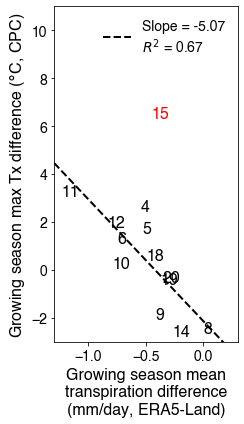

In [85]:
# cpc

import collections

nn_cropland = np.where((crop_all_area_regrid_1d >= 0))[0]

tasmax_max_bias_global_crop_1d = yearly_tasmax_grow_max_bias_cpc.reshape([yearly_tasmax_grow_max_bias_cpc.shape[0], yearly_tasmax_grow_max_bias_cpc.shape[1], \
                                                                  yearly_tasmax_grow_max_bias_cpc.shape[2]*yearly_tasmax_grow_max_bias_cpc.shape[3]])
tasmax_max_bias_global_crop_1d = np.nanmean(np.nanmean(tasmax_max_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
tasmax_max_bias_global_crop_1d_no_miroc6 = tasmax_max_bias_global_crop_1d.copy()
tasmax_max_bias_global_crop_1d_no_miroc6[14] = np.nan


yearly_tran_grow_bias_mean_global_crop_1d = yearly_tran_grow_bias.reshape([yearly_tran_grow_bias.shape[0], yearly_tran_grow_bias.shape[1], \
                                                                  yearly_tran_grow_bias.shape[2]*yearly_tran_grow_bias.shape[3]])
yearly_tran_grow_bias_mean_global_crop_1d = np.nanmean(np.nanmean(yearly_tran_grow_bias_mean_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
yearly_tran_grow_bias_mean_global_crop_1d_no_miroc6 = yearly_tran_grow_bias_mean_global_crop_1d.copy()
yearly_tran_grow_bias_mean_global_crop_1d_no_miroc6[14] = np.nan

nn = np.where(~np.isnan(tasmax_max_bias_global_crop_1d_no_miroc6) & ~np.isnan(yearly_tran_grow_bias_mean_global_crop_1d_no_miroc6))[0]
X = sm.add_constant(yearly_tran_grow_bias_mean_global_crop_1d_no_miroc6[nn])
mdl_tran = sm.OLS(tasmax_max_bias_global_crop_1d_no_miroc6[nn], X).fit()

mdl_leg = {}

x1 = -1.3
x2 = 0.3
plt.figure(figsize=(3.5,6))

# plt.plot([np.nanmean(yearly_tran_grow_bias_mean_global_crop_1d), np.nanmean(yearly_tran_grow_bias_mean_global_crop_1d)], [0,8], '-k')
# plt.plot([x1, x2], [np.nanmean(tasmax_max_bias_global_crop_1d), np.nanmean(tasmax_max_bias_global_crop_1d)], '-k')
plt.gca().set_ylim([-3, 11])
plt.gca().set_xlim([x1, x2])
plt.gca().plot([x1, x2], [mdl_tran.params[0]+x1*mdl_tran.params[1], \
                    mdl_tran.params[0]+x2*mdl_tran.params[1]], '--k', lw=2, label='Slope = %.2f\n$R^2$ = %.2f'%(mdl_tran.params[1], mdl_tran.rsquared))
for m in range(yearly_tran_grow_bias_mean_global_crop_1d.size):
    if not np.isnan(yearly_tran_grow_bias_mean_global_crop_1d[m]) and not np.isnan(tasmax_max_bias_global_crop_1d[m]):
        mdl_leg[m] = cmip6_models[m]
        
        # miroc 6
        if m == 14:
            plt.gca().text(yearly_tran_grow_bias_mean_global_crop_1d[m], tasmax_max_bias_global_crop_1d[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='r')
        else:
            plt.gca().text(yearly_tran_grow_bias_mean_global_crop_1d[m], tasmax_max_bias_global_crop_1d[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='k')
# ax.scatter(yearly_tran_grow_bias_mean_global_crop_1d, tasmax_max_bias_global_crop_1d, s=60, c='k')
plt.gca().set_xlabel('Growing season mean\ntranspiration difference\n(mm/day, ERA5-Land)')
plt.gca().set_ylabel('Growing season max Tx difference ($\degree$C, CPC)')
plt.gca().legend(frameon=False, prop={'size': 14})

mdl_leg_sort = collections.OrderedDict(sorted(mdl_leg.items()))

fake_legend = plt.Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)


ax2_leg_item = []
ax2_leg_label = []
for m in mdl_leg_sort.keys():
    ax2_leg_item.append(fake_legend)
    ax2_leg_label.append('%d - %s'%(m+1, mdl_leg_sort[m]))
# leg2 = ax.legend(ax2_leg_item, ax2_leg_label, frameon=False, loc='upper right', bbox_to_anchor=(1.8, 1.03), prop={'size':14, 'family':'Helvetica'})
# plt.gca().add_artist(leg2)
# plt.gca().add_artist(leg1)
plt.tight_layout()

plt.savefig('evap-bias-model-comparison-era5-cpc.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


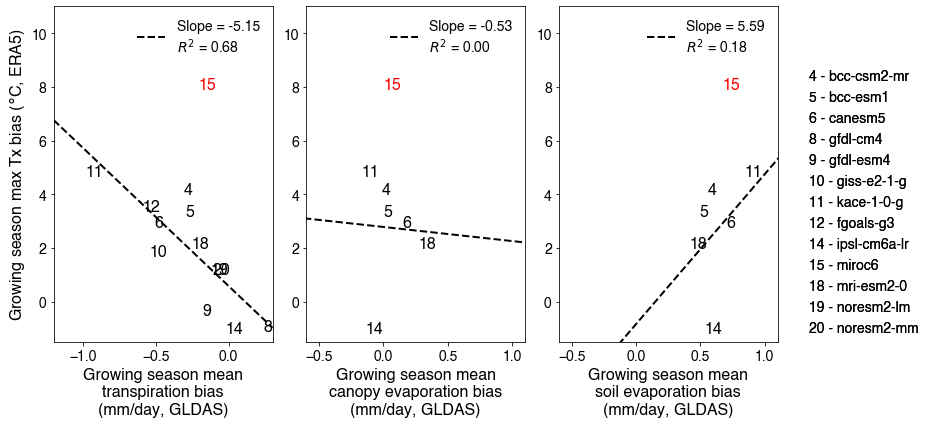

In [87]:
import collections

nn_cropland = np.where((crop_all_area_regrid_1d >= 0))[0]

tasmax_max_bias_global_crop_1d = yearly_tasmax_grow_max_bias.reshape([yearly_tasmax_grow_max_bias.shape[0], yearly_tasmax_grow_max_bias.shape[1], \
                                                                  yearly_tasmax_grow_max_bias.shape[2]*yearly_tasmax_grow_max_bias.shape[3]])
tasmax_max_bias_global_crop_1d = np.nanmean(np.nanmean(tasmax_max_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
tasmax_max_bias_global_crop_1d_no_miroc6 = tasmax_max_bias_global_crop_1d.copy()
tasmax_max_bias_global_crop_1d_no_miroc6[14] = np.nan


yearly_tran_grow_bias_mean_global_crop_gldas_1d = yearly_tran_grow_bias_gldas.reshape([yearly_tran_grow_bias_gldas.shape[0], yearly_tran_grow_bias_gldas.shape[1], \
                                                                  yearly_tran_grow_bias_gldas.shape[2]*yearly_tran_grow_bias_gldas.shape[3]])
yearly_tran_grow_bias_mean_global_crop_gldas_1d = np.nanmean(np.nanmean(yearly_tran_grow_bias_mean_global_crop_gldas_1d[:, :, nn_cropland], axis=2), axis=1)
yearly_tran_grow_bias_mean_global_crop_gldas_1d_no_miroc6 = yearly_tran_grow_bias_mean_global_crop_gldas_1d.copy()
yearly_tran_grow_bias_mean_global_crop_gldas_1d_no_miroc6[14] = np.nan

nn = np.where(~np.isnan(tasmax_max_bias_global_crop_1d_no_miroc6) & ~np.isnan(yearly_tran_grow_bias_mean_global_crop_gldas_1d_no_miroc6))[0]
X = sm.add_constant(yearly_tran_grow_bias_mean_global_crop_gldas_1d_no_miroc6[nn])
mdl_tran = sm.OLS(tasmax_max_bias_global_crop_1d_no_miroc6[nn], X).fit()



yearly_evap_from_canopy_grow_bias_mean_global_crop_gldas_1d = yearly_canopy_evap_grow_bias_gldas.reshape([yearly_canopy_evap_grow_bias_gldas.shape[0], yearly_canopy_evap_grow_bias_gldas.shape[1], \
                                                                  yearly_canopy_evap_grow_bias_gldas.shape[2]*yearly_canopy_evap_grow_bias_gldas.shape[3]])
yearly_evap_from_canopy_grow_bias_mean_global_crop_gldas_1d = np.nanmean(np.nanmean(yearly_evap_from_canopy_grow_bias_mean_global_crop_gldas_1d[:, :, nn_cropland], axis=2), axis=1)
yearly_evap_from_canopy_grow_bias_mean_global_crop_gldas_1d_no_miroc6 = yearly_evap_from_canopy_grow_bias_mean_global_crop_gldas_1d.copy()
yearly_evap_from_canopy_grow_bias_mean_global_crop_gldas_1d_no_miroc6[14] = np.nan

nn = np.where(~np.isnan(tasmax_max_bias_global_crop_1d_no_miroc6) & ~np.isnan(yearly_evap_from_canopy_grow_bias_mean_global_crop_gldas_1d_no_miroc6))[0]
X = sm.add_constant(yearly_evap_from_canopy_grow_bias_mean_global_crop_gldas_1d_no_miroc6[nn])
mdl_canopy = sm.OLS(tasmax_max_bias_global_crop_1d_no_miroc6[nn], X).fit()



yearly_evap_from_soil_grow_bias_mean_global_crop_gldas_1d = yearly_soil_evap_grow_bias_gldas.reshape([yearly_soil_evap_grow_bias_gldas.shape[0], yearly_soil_evap_grow_bias_gldas.shape[1], \
                                                                  yearly_soil_evap_grow_bias_gldas.shape[2]*yearly_soil_evap_grow_bias_gldas.shape[3]])
yearly_evap_from_soil_grow_bias_mean_global_crop_gldas_1d = np.nanmean(np.nanmean(yearly_evap_from_soil_grow_bias_mean_global_crop_gldas_1d[:, :, nn_cropland], axis=2), axis=1)
yearly_evap_from_soil_grow_bias_mean_global_crop_gldas_1d_no_miroc6 = yearly_evap_from_soil_grow_bias_mean_global_crop_gldas_1d.copy()
yearly_evap_from_soil_grow_bias_mean_global_crop_gldas_1d_no_miroc6[14] = np.nan


nn = np.where(~np.isnan(tasmax_max_bias_global_crop_1d_no_miroc6) & ~np.isnan(yearly_evap_from_soil_grow_bias_mean_global_crop_gldas_1d_no_miroc6))[0]
X = sm.add_constant(yearly_evap_from_soil_grow_bias_mean_global_crop_gldas_1d_no_miroc6[nn])
mdl_soil = sm.OLS(tasmax_max_bias_global_crop_1d_no_miroc6[nn], X).fit()


mdl_leg = {}

x1 = -1.2
x2 = 0.3
fig, ax = plt.subplots(1,3,figsize=(11,6))

# plt.plot([np.nanmean(yearly_tran_grow_bias_mean_global_crop_1d), np.nanmean(yearly_tran_grow_bias_mean_global_crop_1d)], [0,8], '-k')
# plt.plot([x1, x2], [np.nanmean(tasmax_max_bias_global_crop_1d), np.nanmean(tasmax_max_bias_global_crop_1d)], '-k')
ax[0].set_ylim([-1.5, 11])
ax[0].set_xlim([-1.2, .3])
ax[0].plot([x1, x2], [mdl_tran.params[0]+x1*mdl_tran.params[1], \
                    mdl_tran.params[0]+x2*mdl_tran.params[1]], '--k', lw=2, label='Slope = %.2f\n$R^2$ = %.2f'%(mdl_tran.params[1], mdl_tran.rsquared))
for m in range(yearly_tran_grow_bias_mean_global_crop_gldas_1d.size):
    if not np.isnan(yearly_tran_grow_bias_mean_global_crop_gldas_1d[m]) and not np.isnan(tasmax_max_bias_global_crop_1d[m]):
        mdl_leg[m] = cmip6_models[m]
        
        # miroc 6
        if m == 14:
            ax[0].text(yearly_tran_grow_bias_mean_global_crop_gldas_1d[m], tasmax_max_bias_global_crop_1d[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='r')
        else:
            ax[0].text(yearly_tran_grow_bias_mean_global_crop_gldas_1d[m], tasmax_max_bias_global_crop_1d[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='k')
# ax[0].scatter(yearly_tran_grow_bias_mean_global_crop_gldas_1d, tasmax_max_bias_global_crop_1d, s=60, c='k')
ax[0].set_xlabel('Growing season mean\ntranspiration bias\n(mm/day, GLDAS)')
ax[0].set_ylabel('Growing season max Tx bias ($\degree$C, ERA5)')
ax[0].legend(frameon=False, prop={'size': 14})

x1 = -.7
x2 = 1.2
ax[1].set_ylim([-1.5, 11])
ax[1].set_xlim([-.6, 1.1])
ax[1].plot([x1, x2], [mdl_canopy.params[0]+x1*mdl_canopy.params[1], \
                    mdl_canopy.params[0]+x2*mdl_canopy.params[1]], '--k', lw=2, label='Slope = %.2f\n$R^2$ = %.2f'%(mdl_canopy.params[1], mdl_canopy.rsquared))
for m in range(yearly_tran_grow_bias_mean_global_crop_gldas_1d.size):
    if not np.isnan(yearly_evap_from_canopy_grow_bias_mean_global_crop_gldas_1d[m]) and not np.isnan(tasmax_max_bias_global_crop_1d[m]):
        mdl_leg[m] = cmip6_models[m]
        # miroc 6
        if m == 14:
            ax[1].text(yearly_evap_from_canopy_grow_bias_mean_global_crop_gldas_1d[m], tasmax_max_bias_global_crop_1d[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='r')
        else:
            ax[1].text(yearly_evap_from_canopy_grow_bias_mean_global_crop_gldas_1d[m], tasmax_max_bias_global_crop_1d[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='k')

# ax[1].scatter(yearly_evap_from_canopy_grow_bias_mean_global_crop_gldas_1d, tasmax_max_bias_global_crop_1d, s=60, c='k')
ax[1].set_xlabel('Growing season mean\ncanopy evaporation bias\n(mm/day, GLDAS)')
ax[1].legend(frameon=False, prop={'size': 14})



x1 = -.7
x2 = 1.2
ax[2].set_xlim([-.6, 1.1])
ax[2].set_ylim([-1.5, 11])
ax[2].plot([x1, x2], [mdl_soil.params[0]+x1*mdl_soil.params[1], \
                    mdl_soil.params[0]+x2*mdl_soil.params[1]], '--k', lw=2, label='Slope = %.2f\n$R^2$ = %.2f'%(mdl_soil.params[1], mdl_soil.rsquared))
for m in range(yearly_evap_from_soil_grow_bias_mean_global_crop_gldas_1d.size):
    if not np.isnan(yearly_evap_from_soil_grow_bias_mean_global_crop_gldas_1d[m]) and not np.isnan(tasmax_max_bias_global_crop_1d[m]):
        mdl_leg[m] = cmip6_models[m]
        
        # miroc 6
        if m == 14:
            ax[2].text(yearly_evap_from_soil_grow_bias_mean_global_crop_gldas_1d[m], tasmax_max_bias_global_crop_1d[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='r')
        else:
            ax[2].text(yearly_evap_from_soil_grow_bias_mean_global_crop_gldas_1d[m], tasmax_max_bias_global_crop_1d[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center', c='k')

# ax[2].scatter(yearly_evap_from_soil_grow_bias_mean_global_crop_gldas_1d, tasmax_max_bias_global_crop_1d, s=60, c='k')
ax[2].set_xlabel('Growing season mean\nsoil evaporation bias\n(mm/day, GLDAS)')
leg1 = ax[2].legend(frameon=False, prop={'size': 14})
# plt.suptitle('All land', fontsize=20)


mdl_leg_sort = collections.OrderedDict(sorted(mdl_leg.items()))

fake_legend = plt.Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)


ax2_leg_item = []
ax2_leg_label = []
for m in mdl_leg_sort.keys():
    ax2_leg_item.append(fake_legend)
    ax2_leg_label.append('%d - %s'%(m+1, mdl_leg_sort[m]))
leg2 = ax[2].legend(ax2_leg_item, ax2_leg_label, frameon=False, loc='upper right', bbox_to_anchor=(1.7, .85), prop={'size':14, 'family':'Helvetica'})
ax[2].add_artist(leg2)
ax[2].add_artist(leg1)
plt.tight_layout()

# plt.savefig('evap-bias-model-comparison.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


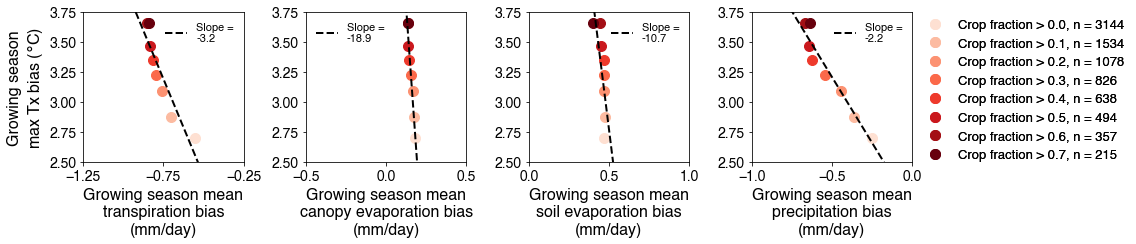

In [67]:
# NOW SHOW BOTTOM PLOTS WITH VARYING CROPLAND

fig, ax = plt.subplots(1,4,figsize=(13,3.5))

cmap = plt.get_cmap('Reds')
lims = np.arange(0, .71, .1)#[0, .01, .05, .1, .15, .25, .4]

ax2_leg_lines = []
ax2_leg_label = []

tran_x = np.full([len(lims)], np.nan)
evap_canopy_x = np.full([len(lims)], np.nan)
evap_soil_x = np.full([len(lims)], np.nan)
pr_x = np.full([len(lims)], np.nan)
temp_y = np.full([len(lims)], np.nan)

for i, lim in enumerate(lims):
    nn_cropland = np.where((crop_all_area_regrid_1d > lim))[0]

    tasmax_max_bias_global_crop_1d = yearly_tasmax_grow_max_bias.reshape([yearly_tasmax_grow_max_bias.shape[0], yearly_tasmax_grow_max_bias.shape[1], \
                                                                      yearly_tasmax_grow_max_bias.shape[2]*yearly_tasmax_grow_max_bias.shape[3]])
    tasmax_max_bias_global_crop_1d = np.nanmean(np.nanmean(tasmax_max_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
    yearly_tran_grow_bias_mean_global_crop_1d = yearly_tran_grow_bias.reshape([yearly_tran_grow_bias.shape[0], yearly_tran_grow_bias.shape[1], \
                                                                      yearly_tran_grow_bias.shape[2]*yearly_tran_grow_bias.shape[3]])
    yearly_tran_grow_bias_mean_global_crop_1d = np.nanmean(np.nanmean(yearly_tran_grow_bias_mean_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)

    yearly_evap_from_canopy_grow_bias_mean_global_crop_1d = yearly_evap_from_canopy_grow_bias.reshape([yearly_evap_from_canopy_grow_bias.shape[0], yearly_evap_from_canopy_grow_bias.shape[1], \
                                                                      yearly_evap_from_canopy_grow_bias.shape[2]*yearly_evap_from_canopy_grow_bias.shape[3]])
    yearly_evap_from_canopy_grow_bias_mean_global_crop_1d = np.nanmean(np.nanmean(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)


    yearly_evap_from_soil_grow_bias_mean_global_crop_1d = yearly_evap_from_soil_grow_bias.reshape([yearly_evap_from_soil_grow_bias.shape[0], yearly_evap_from_soil_grow_bias.shape[1], \
                                                                      yearly_evap_from_soil_grow_bias.shape[2]*yearly_evap_from_soil_grow_bias.shape[3]])
    yearly_evap_from_soil_grow_bias_mean_global_crop_1d = np.nanmean(np.nanmean(yearly_evap_from_soil_grow_bias_mean_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
    
    
    yearly_pr_grow_bias_mean_global_crop_1d = yearly_pr_grow_bias.reshape([yearly_pr_grow_bias.shape[0], yearly_pr_grow_bias.shape[1], \
                                                                      yearly_pr_grow_bias.shape[2]*yearly_pr_grow_bias.shape[3]])
    yearly_pr_grow_bias_mean_global_crop_1d = np.nanmean(np.nanmean(yearly_pr_grow_bias_mean_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)

    ax[0].plot(np.nanmean(yearly_tran_grow_bias_mean_global_crop_1d), np.nanmean(tasmax_max_bias_global_crop_1d), 'o', markersize=10, color=cmap(((i+1)/len(lims))))
    tran_x[i] = np.nanmean(yearly_tran_grow_bias_mean_global_crop_1d)
    temp_y[i] = np.nanmean(tasmax_max_bias_global_crop_1d)
    
    ax[1].plot(np.nanmean(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d), np.nanmean(tasmax_max_bias_global_crop_1d), 'o', markersize=10, color=cmap(((i+1)/len(lims))))
    evap_canopy_x[i] = np.nanmean(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d)
    
    ax[2].plot(np.nanmean(yearly_evap_from_soil_grow_bias_mean_global_crop_1d), np.nanmean(tasmax_max_bias_global_crop_1d), 'o', markersize=10, color=cmap(((i+1)/len(lims))))
    evap_soil_x[i] = np.nanmean(yearly_evap_from_soil_grow_bias_mean_global_crop_1d)
    
    p = ax[3].plot(np.nanmean(yearly_pr_grow_bias_mean_global_crop_1d), np.nanmean(tasmax_max_bias_global_crop_1d), 'o', markersize=10, color=cmap(((i+1)/len(lims))))
    pr_x[i] = np.nanmean(yearly_pr_grow_bias_mean_global_crop_1d)
    
    ax2_leg_lines.append(p)
    ax2_leg_label.append('Crop fraction > %.1f, n = %d'%(lim, len(nn_cropland)))

X = sm.add_constant(tran_x)
mdl = sm.OLS(temp_y, X).fit()
x1 = -.475
x2 = -1.0

# ax[0].set_xlabel('Mean transpiration\nbias (mm/day)')
ax[0].set_xlim([-1.25,-.25])
ax[0].set_ylim([2.5,3.75])
ax[0].plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=2, label='Slope =\n%.1f'%mdl.params[1])
ax[0].set_ylabel('Growing season\nmax Tx bias ($\degree$C)')
ax[0].set_xlabel('Growing season mean\ntranspiration bias\n(mm/day)')
ax[0].set_xticks([-1.25, -.75, -.25])
ax[0].legend(frameon=False, prop={'size': 11})


X = sm.add_constant(evap_canopy_x)
mdl = sm.OLS(temp_y, X).fit()
x1 = .23
x2 = .1

# ax[1].set_xlabel('Mean canopy evaporation\nbias (mm/day)')
ax[1].set_xlim([-.5,.5])
ax[1].set_ylim([2.5,3.75])
ax[1].plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=2, label='Slope =\n%.1f'%mdl.params[1])
# ax[1].set_ylabel('Max growing season\ntasmax bias ($\degree$C)')
ax[1].set_xlabel('Growing season mean\ncanopy evaporation bias\n(mm/day)')
ax[1].set_xticks([-.5, 0, .5])
ax[1].legend(frameon=False, prop={'size': 11})
    
    
X = sm.add_constant(evap_soil_x)
mdl = sm.OLS(temp_y, X).fit()
x1 = .35
x2 = .625
# ax[2].set_xlabel('Mean soil evaporation\nbias (mm/day)')
ax[2].set_xlim([0,1])
ax[2].set_ylim([2.5,3.75])
ax[2].plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=2, label='Slope =\n%.1f'%mdl.params[1])
# ax[2].set_ylabel('Max growing season\ntasmax bias ($\degree$C)')
ax[2].set_xlabel('Growing season mean\nsoil evaporation bias\n(mm/day)')
ax[2].set_xticks([0, .5, 1])
ax[2].legend(frameon=False, prop={'size': 11})


X = sm.add_constant(pr_x)
mdl = sm.OLS(temp_y, X).fit()
x1 = -1
x2 = 0
ax[3].set_xlim([-1,0])
ax[3].set_ylim([2.5,3.75])
ax[3].plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=2, label='Slope =\n%.1f'%mdl.params[1])
# ax[2].set_ylabel('Max growing season\ntasmax bias ($\degree$C)')
ax[3].set_xlabel('Growing season mean\nprecipitation bias\n(mm/day)')
ax[3].set_xticks([-1, -.5, 0])
leg1 = ax[3].legend(frameon=False, prop={'size': 11})


leg2 = ax[3].legend(ax2_leg_label, frameon=False, loc='upper right', bbox_to_anchor=(2.4, 1.03), prop={'size':13, 'family':'Helvetica'})
ax[3].add_artist(leg2)
ax[3].add_artist(leg1)

# leg1 = ax[2].legend(p, frameon=False, prop={'size': 11})
# leg2 = ax[2].legend(ax2_leg_label, frameon=False, bbox_to_anchor=(1.0, 1), prop={'size': 13})
# ax[2].add_artist(leg1)

# plt.suptitle('Global cropland (fraction > 0)', fontsize=20)
plt.tight_layout()

# plt.savefig('evap-bias-model-avg.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

NameError: name 'label' is not defined

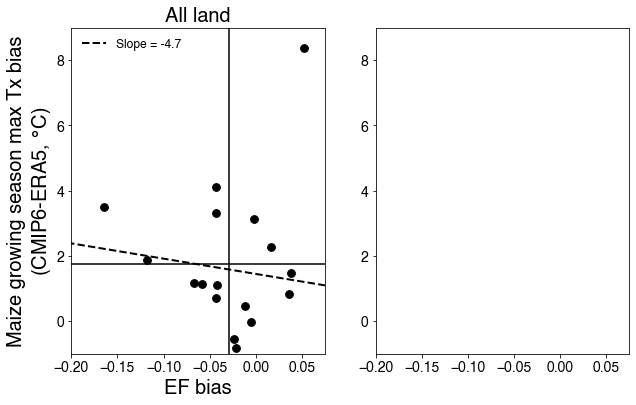

In [66]:

x1 = -.25
x2 = .075
fig, ax = plt.subplots(1,2,figsize=(10,6))
ax[0].set_xlim([-.2, .075])
ax[0].set_ylim([-1, 9])


nn_cropland = np.where((crop_all_area_regrid_1d >= 0))[0]

tasmax_max_bias_global_crop_1d = yearly_tasmax_grow_max_bias.reshape([yearly_tasmax_grow_max_bias.shape[0], yearly_tasmax_grow_max_bias.shape[1], \
                                                                  yearly_tasmax_grow_max_bias.shape[2]*yearly_tasmax_grow_max_bias.shape[3]])
tasmax_max_bias_global_crop_1d = np.nanmean(np.nanmean(tasmax_max_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
ef_mean_bias_global_crop_1d = yearly_ef_grow_bias.reshape([yearly_ef_grow_bias.shape[0], yearly_ef_grow_bias.shape[1], \
                                                                  yearly_ef_grow_bias.shape[2]*yearly_ef_grow_bias.shape[3]])
ef_mean_bias_global_crop_1d = np.nanmean(np.nanmean(ef_mean_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)


nn = np.where(~np.isnan(tasmax_max_bias_global_crop_1d) & ~np.isnan(ef_mean_bias_global_crop_1d))[0]
X = sm.add_constant(ef_mean_bias_global_crop_1d[nn])
mdl = sm.RLM(tasmax_max_bias_global_crop_1d[nn], X).fit()


ax[0].plot([np.nanmean(ef_mean_bias_global_crop_1d), np.nanmean(ef_mean_bias_global_crop_1d)], [-1,9], '-k')
ax[0].plot([x1, x2], [np.nanmean(tasmax_max_bias_global_crop_1d), np.nanmean(tasmax_max_bias_global_crop_1d)], '-k')
ax[0].plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], \
                    mdl.params[0]+x2*mdl.params[1]], '--', lw=2, color='k', label='Slope = %.1f'%mdl.params[1])
ax[0].scatter(ef_mean_bias_global_crop_1d, tasmax_max_bias_global_crop_1d, s=60, color='k')
ax[0].set_xlabel('EF bias', fontsize=20)
ax[0].set_ylabel('Maize growing season max Tx bias\n(CMIP6-ERA5, $\degree$C)', fontsize=20)
ax[0].set_title('All land', fontsize=20)
ax[0].legend(frameon=False, prop={'size': 12})

ax[1].set_xlim([-.2, .075])
ax[1].set_ylim([-1, 9])

cmap = plt.get_cmap('Reds')
lims = np.arange(0, .71, .1)#[0, .01, .05, .1, .15, .25, .4]

leg2_label = []
leg1_label = []

for i, lim in enumerate(lims):
    nn_cropland = np.where((crop_all_area_regrid_1d > lim))[0]
    
    tasmax_max_bias_global_crop_1d = yearly_tasmax_grow_max_bias.reshape([yearly_tasmax_grow_max_bias.shape[0], yearly_tasmax_grow_max_bias.shape[1], \
                                                                      yearly_tasmax_grow_max_bias.shape[2]*yearly_tasmax_grow_max_bias.shape[3]])
    tasmax_max_bias_global_crop_1d = np.nanmean(np.nanmean(tasmax_max_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
    ef_mean_bias_global_crop_1d = yearly_ef_grow_bias.reshape([yearly_ef_grow_bias.shape[0], yearly_ef_grow_bias.shape[1], \
                                                                      yearly_ef_grow_bias.shape[2]*yearly_ef_grow_bias.shape[3]])
    ef_mean_bias_global_crop_1d = np.nanmean(np.nanmean(ef_mean_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)

    nn = np.where(~np.isnan(tasmax_max_bias_global_crop_1d) & ~np.isnan(ef_mean_bias_global_crop_1d))[0]
    X = sm.add_constant(ef_mean_bias_global_crop_1d[nn])
    mdl = sm.RLM(tasmax_max_bias_global_crop_1d[nn], X).fit()

    if i == 0:
        leg2_label.append('Crop fraction > %.1f, n = %d'%(lim, len(nn_cropland)))
        leg1_label.append('Slope = %.1f'%(mdl.params[1]))
    else:
        leg2_label.append('Crop fraction > %.1f, n = %d'%(lim, len(nn_cropland)))
        leg1_label.append('Slope = %.1f'%(mdl.params[1]))
    
    ax[1].plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], \
                        mdl.params[0]+x2*mdl.params[1]], '--', lw=2, color=cmap(((i+1)/len(lims))), label=label)
    
    

# ax[1].legend(loc='upper right', frameon=False)
# ax[1].plot([0, 0], [0,8], '-k')
leg1 = ax[1].legend(leg1_label, frameon=False, prop={'size': 12})
leg2 = ax[1].legend(leg2_label, frameon=False, bbox_to_anchor=(1.0, .75), prop={'size': 14})
ax[1].add_artist(leg1)
ax[1].set_title('Cropland', fontsize=20)

# now draw markers for ef/bias averages
for i, lim in enumerate(lims):
    nn_cropland = np.where((crop_all_area_regrid_1d > lim))[0]

    tasmax_max_bias_global_crop_1d = yearly_tasmax_grow_max_bias.reshape([yearly_tasmax_grow_max_bias.shape[0], yearly_tasmax_grow_max_bias.shape[1], \
                                                                      yearly_tasmax_grow_max_bias.shape[2]*yearly_tasmax_grow_max_bias.shape[3]])
    tasmax_max_bias_global_crop_1d = np.nanmean(np.nanmean(tasmax_max_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
    ef_mean_bias_global_crop_1d = yearly_ef_grow_bias.reshape([yearly_ef_grow_bias.shape[0], yearly_ef_grow_bias.shape[1], \
                                                                      yearly_ef_grow_bias.shape[2]*yearly_ef_grow_bias.shape[3]])
    ef_mean_bias_global_crop_1d = np.nanmean(np.nanmean(ef_mean_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
    ax[1].plot(np.nanmean(ef_mean_bias_global_crop_1d), np.nanmean(tasmax_max_bias_global_crop_1d), 'o', markersize=15, markeredgecolor='k', color=cmap(((i+1)/len(lims))))

# plt.scatter(ef_mean_bias_global_crop_1d, tasmax_max_bias_global_crop_1d, s=60)
plt.xlabel('EF bias', fontsize=20)
# plt.ylabel('Maize growing season max Tx bias (CMIP6-ERA5, $\degree$C)')
# plt.title('Global cropland (varied fractions)')

plt.tight_layout()
# plt.savefig('ef-bias-model-comparison.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)